# Overview

While GPS has become a ubiquitous solution for outdoor real-time locating, RTLS technology has evolved and become much more prevalent for indoor tracking. The RTLS data set used in this exercise is comprised of MAC addresses from recorded connections made to routers within a location. Signal strength is measured at every router (network access point) via a mobile scanning device. Measuring signal strength for these routers at various locations enable us to create a reference dataset on which to base device position predictions.

Nolan and Lang try to predict the location of devices using different access points in a building. They use K nearest neighbor algorithm. In this case study, we initially investigate the Nolan and Lang code and analyze the impact of an extra access point that they dropped from the dataset. We will ask ourselves if it was a good decision. We will also analyze if retaining the access point will lead to a more accurate result. Finally, we will use a weighted Euclidean distance technique to predict the location. Initially we analyze the Nolan and Lang code line by line and then we will try to answer the mentioned questions. 

The steps used for this analysis are: exploratory analysis, data cleansing, signal strength and time analysis, analysis of accuracy of the model with certain features, implementation of kNN with different distance, and comparison of kNN approaches to determine the best location prediction method.

Our code includes modified versions examples found in Data Science in R: A Case Studies Approach to Computational Reasoning and Problem Solving, Chapter 1, pages 3-40 as well as from a R notebook from class.

# Reading the data
Following code will read the data from the url and store it in txt variable.

In [368]:
seed <- 763
set.seed(seed = seed)
library(data.table)

options(digits = 2)

txt <- readLines('data/offline.final.trace.txt')

head(txt)



[1] "# timestamp=2006-02-11 08:31:58"                                                                                                                                                                                                                                                                                                                                                                                                                                 
[2] "# usec=250"                                                                                                                                                                                                                                                                                                                                                                                                                                                      
[3] "# minReadings=110"                                                                                                                                                                                                                                                                                                                                                                                                                                               
[4] "t=1139643118358;id=00:02:2D:21:0F:33;pos=0.0,0.0,0.0;degree=0.0;00:14:bf:b1:97:8a=-38,2437000000,3;00:14:bf:b1:97:90=-56,2427000000,3;00:0f:a3:39:e1:c0=-53,2462000000,3;00:14:bf:b1:97:8d=-65,2442000000,3;00:14:bf:b1:97:81=-65,2422000000,3;00:14:bf:3b:c7:c6=-66,2432000000,3;00:0f:a3:39:dd:cd=-75,2412000000,3;00:0f:a3:39:e0:4b=-78,2462000000,3;00:0f:a3:39:e2:10=-87,2437000000,3;02:64:fb:68:52:e6=-88,2447000000,1;02:00:42:55:31:00=-84,2457000000,1"
[5] "t=1139643118744;id=00:02:2D:21:0F:33;pos=0.0,0.0,0.0;degree=0.0;00:14:bf:b1:97:8a=-38,2437000000,3;00:0f:a3:39:e1:c0=-54,2462000000,3;00:14:bf:b1:97:90=-56,2427000000,3;00:14:bf:3b:c7:c6=-67,2432000000,3;00:14:bf:b1:97:81=-66,2422000000,3;00:14:bf:b1:97:8d=-70,2442000000,3;00:0f:a3:39:e0:4b=-79,2462000000,3;00:0f:a3:39:dd:cd=-73,2412000000,3;00:0f:a3:39:e2:10=-83,2437000000,3;02:00:42:55:31:00=-85,2457000000,1"                                   
[6] "t=1139643119002;id=00:02:2D:21:0F:33;pos=0.0,0.0,0.0;degree=0.0;00:14:bf:b1:97:8a=-38,2437000000,3;00:0f:a3:39:e1:c0=-54,2462000000,3;00:14:bf:b1:97:90=-57,2427000000,3;00:14:bf:b1:97:81=-66,2422000000,3;00:14:bf:3b:c7:c6=-69,2432000000,3;00:14:bf:b1:97:8d=-70,2442000000,3;00:0f:a3:39:e0:4b=-78,2462000000,3;00:0f:a3:39:e2:10=-83,2437000000,3;00:0f:a3:39:dd:cd=-65,2412000000,3;02:64:fb:68:52:e6=-90,2447000000,1"

# Exploratory Data Analysis
Following lines explains the data:

* t  "Timestamp" 
* id "MACofScanDevice"
* pos "RealPosition"
* degree "orientation"
* MACofResponse1 = "SignalStrengthValue,Frequency,Mode" ...
* MACofResponseN = "SignalStrengthValue,Frequency,Mode"

These reference locations give us a calibration set of signal strengths for the building, and we use them to build our model to predict the locations of the hand-held device when its position is unknown.

The columns are self explanatory but some of the above items are compound and should be transformed and cleansed. 



We need to clean the data to transform it into a dataframe. This can be done in two ways:


## First Approach

The first format is to transform each line to reach the following format:

t(timestamp), id(MAC), pos(Real Position), degree, Mac1(first observation of the device), Mac2(second observation), ..., Mac N

### Advantage
Each line in the file corresponds to one line in the dataframe.


### Disadvantage
The number of columns in each line vary as there might be different observations of the data. Hence we need two passes of the data to create the dataframe.


## Second Approach

A second approach is to have the same initial variables describing the hand-held device, i.e., time, MAC address, location, and orientation. After this, we have just 4 other variables: the MAC address of the device from which we received a signal, the signal, the channel and the type of the device.

t(timestamp), id(MAC), pos(Real Position), degree, sender signal, signal, channel, device type


### Advantage
* The data can be read in one shot.
* We can use group by. 


### Disadvantage
The number of columns in each line vary as there might be different observations of the data. Hence we need two passes of the data to create the dataframe.

## Data Cleansing
We will follow the second approach. Commented lines that start with # should also be removed. We will split the 4th column which is a composite column based on semicolon, equal and comma. Then we make sure to choose the rows with valid columns and then focus on the types of numeric columns.



In [369]:
sum(substr(txt, 1, 1) == "#")

length(txt)

 strsplit(txt[4], ";")[[1]]

 tokens = strsplit(txt[4], "[;=,]")[[1]]

tokens[1:10]

 tokens[c(2, 4, 6:8, 10)]

 tokens[  -( 1:10 ) ]

 tmp = matrix(tokens[ - (1:10) ], ncol = 4, byrow = TRUE)
 
 mat = cbind(matrix(tokens[c(2, 4, 6:8, 10)], nrow = nrow(tmp), ncol = 6, byrow = TRUE), tmp)

  dim(mat)

processLine = function(x)
{
  tokens = strsplit(x, "[;=,]")[[1]]
  tmp = matrix(tokens[ - (1:10) ], ncol = 4, byrow = TRUE)
  cbind(matrix(tokens[c(2, 4, 6:8, 10)], nrow = nrow(tmp),
               ncol = 6, byrow = TRUE), tmp)
}

[1] 5312

[1] 151392

[1] "t=1139643118358"                    "id=00:02:2D:21:0F:33"              
 [3] "pos=0.0,0.0,0.0"                    "degree=0.0"                        
 [5] "00:14:bf:b1:97:8a=-38,2437000000,3" "00:14:bf:b1:97:90=-56,2427000000,3"
 [7] "00:0f:a3:39:e1:c0=-53,2462000000,3" "00:14:bf:b1:97:8d=-65,2442000000,3"
 [9] "00:14:bf:b1:97:81=-65,2422000000,3" "00:14:bf:3b:c7:c6=-66,2432000000,3"
[11] "00:0f:a3:39:dd:cd=-75,2412000000,3" "00:0f:a3:39:e0:4b=-78,2462000000,3"
[13] "00:0f:a3:39:e2:10=-87,2437000000,3" "02:64:fb:68:52:e6=-88,2447000000,1"
[15] "02:00:42:55:31:00=-84,2457000000,1"

[1] "t"                 "1139643118358"     "id"               
 [4] "00:02:2D:21:0F:33" "pos"               "0.0"              
 [7] "0.0"               "0.0"               "degree"           
[10] "0.0"

[1] "1139643118358"     "00:02:2D:21:0F:33" "0.0"              
[4] "0.0"               "0.0"               "0.0"

[1] "00:14:bf:b1:97:8a" "-38"               "2437000000"       
 [4] "3"                 "00:14:bf:b1:97:90" "-56"              
 [7] "2427000000"        "3"                 "00:0f:a3:39:e1:c0"
[10] "-53"               "2462000000"        "3"                
[13] "00:14:bf:b1:97:8d" "-65"               "2442000000"       
[16] "3"                 "00:14:bf:b1:97:81" "-65"              
[19] "2422000000"        "3"                 "00:14:bf:3b:c7:c6"
[22] "-66"               "2432000000"        "3"                
[25] "00:0f:a3:39:dd:cd" "-75"               "2412000000"       
[28] "3"                 "00:0f:a3:39:e0:4b" "-78"              
[31] "2462000000"        "3"                 "00:0f:a3:39:e2:10"
[34] "-87"               "2437000000"        "3"                
[37] "02:64:fb:68:52:e6" "-88"               "2447000000"       
[40] "1"                 "02:00:42:55:31:00" "-84"              
[43] "2457000000"        "1"

[1] 11 10

In [370]:
tmp = lapply(txt[4:20], processLine)

 sapply(tmp, nrow)

 offline = as.data.frame(do.call("rbind", tmp))
 
 dim(offline)

 lines = txt[ substr(txt, 1, 1) != "#" ]
 tmp = lapply(lines, processLine)

processLine = function(x)
{
  tokens = strsplit(x, "[;=,]")[[1]]
  
  if (length(tokens) == 10) 
    return(NULL)
 
  tmp = matrix(tokens[ - (1:10) ], , 4, byrow = TRUE)
  cbind(matrix(tokens[c(2, 4, 6:8, 10)], nrow(tmp), 6, 
               byrow = TRUE), tmp)
}

 options(error = recover, warn = 1)
 tmp = lapply(lines, processLine)
 offline = as.data.frame(do.call("rbind", tmp), stringsAsFactors = FALSE)


[1] 11 10 10 11  9 10  9  9 10 11 11  9  9  9  8 10 14

[1] 170  10

Warning message in matrix(tokens[c(2, 4, 6:8, 10)], nrow = nrow(tmp), ncol = 6, :
“la longueur des données dépasse la taille de la matrice”Warning message in matrix(tokens[c(2, 4, 6:8, 10)], nrow = nrow(tmp), ncol = 6, :
“la longueur des données dépasse la taille de la matrice”Warning message in matrix(tokens[c(2, 4, 6:8, 10)], nrow = nrow(tmp), ncol = 6, :
“la longueur des données dépasse la taille de la matrice”Warning message in matrix(tokens[c(2, 4, 6:8, 10)], nrow = nrow(tmp), ncol = 6, :
“la longueur des données dépasse la taille de la matrice”Warning message in matrix(tokens[c(2, 4, 6:8, 10)], nrow = nrow(tmp), ncol = 6, :
“la longueur des données dépasse la taille de la matrice”Warning message in matrix(tokens[c(2, 4, 6:8, 10)], nrow = nrow(tmp), ncol = 6, :
“la longueur des données dépasse la taille de la matrice”

## Type Check
Now the data is ready to be used as a dataframe. The dimension of the data indicates that all 1181628 rows have 10 columns and we can check the types of the variables in the data frame and verify that they are correct. The "rawTime" will also be converted into milliseconds as "time". 

In [371]:
dim(offline)
# head(offline)
names(offline) = c("time", "scanMac", "posX", "posY", "posZ", 
                   "orientation", "mac", "signal", 
                   "channel", "type")

numVars = c("time", "posX", "posY", "posZ", 
            "orientation", "signal")
offline[ numVars ] =  lapply(offline[ numVars ], as.numeric)

offline = offline[ offline$type == "3", ]
offline = offline[ , "type" != names(offline) ]
#offline[1:2]
dim(offline)

offline$rawTime = offline$time
offline$time = offline$time/1000
class(offline$time) = c("POSIXt", "POSIXct")

unlist(lapply(offline, class))  

[1] 1181628      10

[1] 978443      9

time1       time2     scanMac        posX        posY        posZ 
   "POSIXt"   "POSIXct" "character"   "numeric"   "numeric"   "numeric" 
orientation         mac      signal     channel     rawTime 
  "numeric" "character"   "numeric" "character"   "numeric"

In [372]:
summary(offline[, numVars])
summary(sapply(offline[ , c("mac", "channel", "scanMac")], as.factor))

      time                          posX         posY           posZ  
 Min.   :2006-02-10 23:31:58   Min.   : 0   Min.   : 0.0   Min.   :0  
 1st Qu.:2006-02-11 05:21:27   1st Qu.: 2   1st Qu.: 3.0   1st Qu.:0  
 Median :2006-02-11 11:57:58   Median :12   Median : 6.0   Median :0  
 Mean   :2006-02-16 06:57:37   Mean   :14   Mean   : 5.9   Mean   :0  
 3rd Qu.:2006-02-19 06:52:40   3rd Qu.:23   3rd Qu.: 8.0   3rd Qu.:0  
 Max.   :2006-03-09 12:41:10   Max.   :33   Max.   :13.0   Max.   :0  
  orientation      signal   
 Min.   :  0   Min.   :-99  
 1st Qu.: 90   1st Qu.:-69  
 Median :180   Median :-60  
 Mean   :167   Mean   :-62  
 3rd Qu.:270   3rd Qu.:-53  
 Max.   :360   Max.   :-25  

                mac               channel                    scanMac      
 00:0f:a3:39:e1:c0:145862   2462000000:189774   00:02:2D:21:0F:33:978443  
 00:0f:a3:39:dd:cd:145619   2437000000:152124                             
 00:14:bf:b1:97:8a:132962   2412000000:145619                             
 00:14:bf:3b:c7:c6:126529   2432000000:126529                             
 00:14:bf:b1:97:90:122315   2427000000:122315                             
 00:14:bf:b1:97:8d:121325   2442000000:121325                             
 (Other)          :183831   (Other)   :120757                             

## posX and scanMac
The following code prints some information about the numeric and character type columns.
It seems that posZ is always zero (We might remove this variable later) and the scanMac value is always same which indicates that all of the measurements were taken on one floor of the building. We can eliminate this variable as well.

In [373]:
offline = offline[ , !(names(offline) %in% c("scanMac", "posZ"))]

## Orientation Analysis
 The following code indicate that we have 203 different orientation values which is not helpful. In order to predict the location of the device, we should predict movement. If we consolidate the existing values to only 8 values for orientation (e.g. 0, 45, 90, ..., 315), it will help us predict the location more efficiently.  
    

In [374]:
length(unique(offline$orientation))

[1] 203

## 0 and 360 orientation overlap problem
This empirical distribution function of orientation shows that there are 8 basic orientations that are 45 degrees apart. We observe from the steps in the function that these orientations are not exactly 45, 90, 135, etc. Also, the 0 orientation is split into the two groups, one near 0 and the other near 360 as they both refer to the same orientation. Nolan and Lang use roundOrientation function to address this issue and introduce a new variable called angle.
 
 

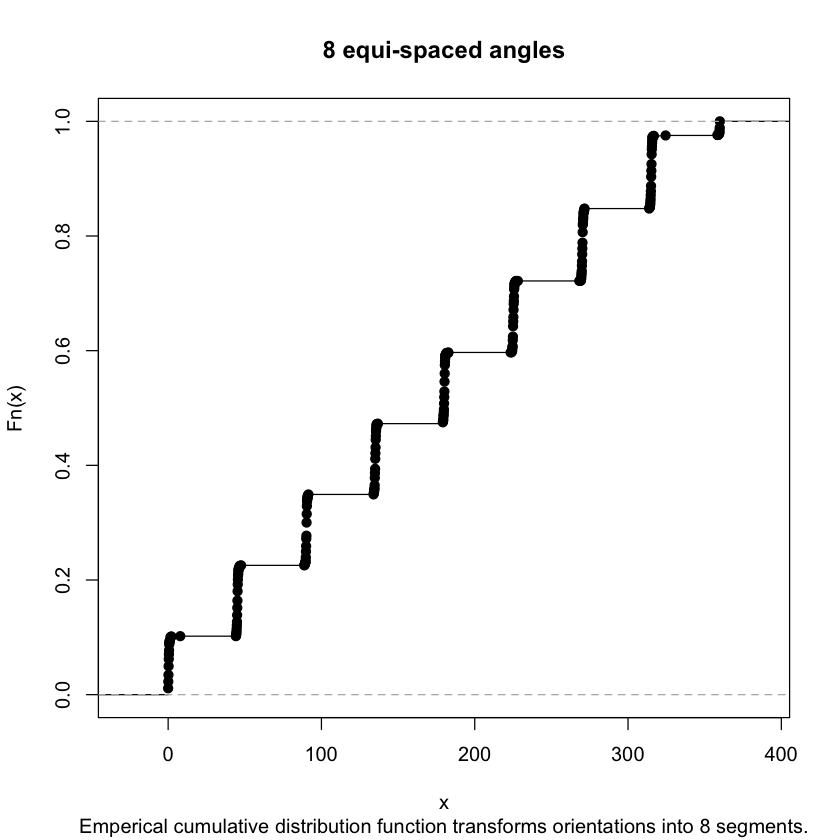

In [375]:
plot(ecdf(offline$orientation), main="8 equi-spaced angles", sub="Emperical cumulative distribution function transforms orientations into 8 segments.")

null device 
          1

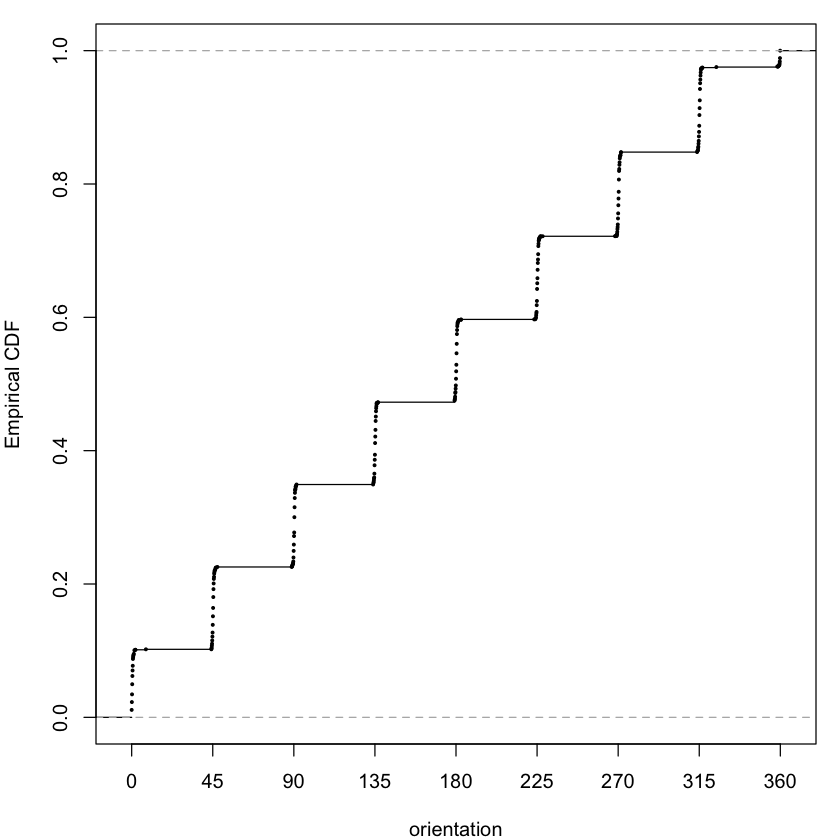

In [376]:
#pdf(file = "Geo_ECDFOrientation.pdf", width = 10, height = 7)
oldPar = par(mar = c(4, 4, 1, 1))
plot(ecdf(offline$orientation), pch = 19, cex = 0.3,
     xlim = c(-5, 365), axes = FALSE,
     xlab = "orientation", ylab = "Empirical CDF", main = "")
box()
axis(2)
axis(side = 1, at = seq(0, 360, by = 45))
par(oldPar)
dev.off()

null device 
          1

null device 
          1

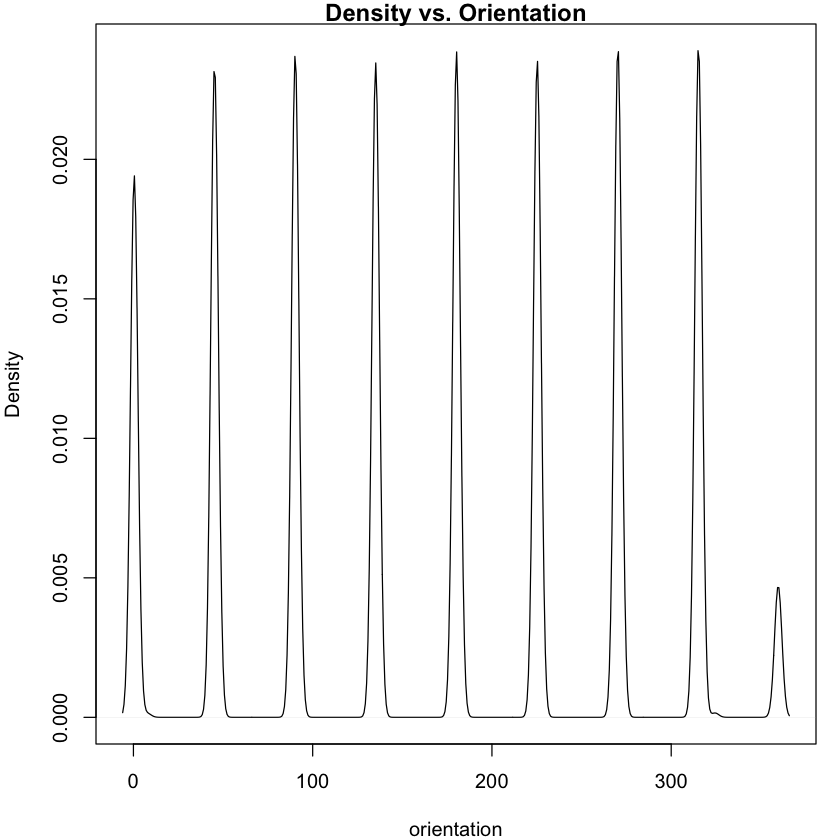

In [377]:
#pdf(file = "Geo_DensityOrientation.pdf", width = 10, height = 5)
oldPar = par(mar = c(4, 4, 1, 1))
plot(density(offline$orientation, bw = 2), 
 xlab = "orientation", main = "")
title("Density vs. Orientation")

par(oldPar)
dev.off()

roundOrientation = function(angles) {
  refs = seq(0, by = 45, length  = 9)
  q = sapply(angles, function(o) which.min(abs(o - refs)))
  c(refs[1:8], 0)[q]
}

offline$angle = roundOrientation(offline$orientation)

#pdf(file = "Geo_BoxplotAngle.pdf", width = 10)
oldPar = par(mar = c(4, 4, 1, 1))

par(oldPar)
dev.off()

From the summary() information, it seems that there may be a one-to-one mapping between the MAC address of the access 
points and channel. For example, the summary statistics show there are 126,529 occurrences of the address 00:14:bf:3b:c7:c6 and the same number of occurrences of channel 2432000000. To help us ascertain if we do have a one- to-one mapping, we look at the relationship between the MAC address and channel.
How many unique addresses and channels do we have? There should be the same number, if there is a one-to-one mapping. We find the following:


In [378]:
c(length(unique(offline$mac)), length(unique(offline$channel)))

[1] 12  8

There are 12 MAC addresses and 8 channels. We were given the impression from the building plan that there are only 6 access points. Why are there 8 channels and 12 MAC addresses? Rereading the documentation we find that there are additional access points that are not part of the testing area and so not seen on the floor plan. Let’s check the counts of observations for the various MAC addresses with table():

## Access Points
According to the documentation, the access points consist of 5 Linksys/Cisco and one Lancom L-54g routers. We look up these MAC addresses at the http://coffer.com/mac_find/ site to find the vendor addresses that begin with 00:14:bf belong to Linksys devices, those beginning with 00:0f:a3 belong to Alpha Networks, and Lancom devices start with 00:a0:57 (see Figure 1.4). We do have 5 devices with an address that begins 00:14:bf, which matches with the Linksys count from the documentation. However, none of our MAC addresses begin with 00:a0:57 so there is a discrepancy with the documentation. Please recall that there are potentially signals recorded at 166 grid points, 8 orientations, and 110 replications. 

The third and fifth above addresses are not among the access points displayed on the map because they have much lower counts than the others and these are far lower than the possible 146,080 recordings. For now, we keep records of our top 7 devices.   

In [379]:
table(offline$mac)

subMacs = names(sort(table(offline$mac), decreasing = TRUE))[1:7]


00:04:0e:5c:23:fc 00:0f:a3:39:dd:cd 00:0f:a3:39:e0:4b 00:0f:a3:39:e1:c0 
              418            145619             43508            145862 
00:0f:a3:39:e2:10 00:14:bf:3b:c7:c6 00:14:bf:b1:97:81 00:14:bf:b1:97:8a 
            19162            126529            120339            132962 
00:14:bf:b1:97:8d 00:14:bf:b1:97:90 00:30:bd:f8:7f:c5 00:e0:63:82:8b:a9 
           121325            122315               301               103 

Due to one to one correspondence of channel and MAC address of our top 7 devices, we eliminate the channel. 

In [380]:
offline = offline[ offline$mac %in% subMacs, ]
macChannel = with(offline, table(mac, channel))
apply(macChannel, 1, function(x) sum(x > 0))

offline = offline[ , "channel" != names(offline)]

00:0f:a3:39:dd:cd 00:0f:a3:39:e1:c0 00:14:bf:3b:c7:c6 00:14:bf:b1:97:81 
                1                 1                 1                 1 
00:14:bf:b1:97:8a 00:14:bf:b1:97:8d 00:14:bf:b1:97:90 
                1                 1                 1

## Position of the Hand-Held Device
we consider the position variables, posX and posY. For how many different locations do we have data? The by() function can tally up the numbers of rows in our data frame for each unique (x, y) combination. We begin by creating a list containing a data frame for each location as follows and remove the 310 null elements:

In [381]:
locDF = with(offline, 
             by(offline, list(posX, posY), function(x) x))
length(locDF)


sum(sapply(locDF, is.null))

locDF = locDF[ !sapply(locDF, is.null) ]

length(locDF)

[1] 476

[1] 310

[1] 166

We can now operate on all 166 data frames to determine the number of observations recorded
at each location. The next sapply function will keep the position information with the location and then we can confirm that "locCounts" is a matrix with 3 rows:

In [382]:
locCounts = sapply(locDF, nrow)

locCounts = sapply(locDF, 
                   function(df) 
                     c(df[1, c("posX", "posY")], count = nrow(df)))

class(locCounts)

dim(locCounts)

[1] "matrix"

[1]   3 166

As the following code illustrates, examining a few of the location data indicates that we have about 5500 records per position. With 7 access points in place and the 8 orientations that we cleansed, there are 110 replications of the data. This becomes 6,160 signal strength measurements. 

This matrix can be plotted and it gives us a very good overview of the presence of devices on different locations. The following code illustrates this data and as you can see, not all signals were detected, so there are about 5500 recordings at each location:

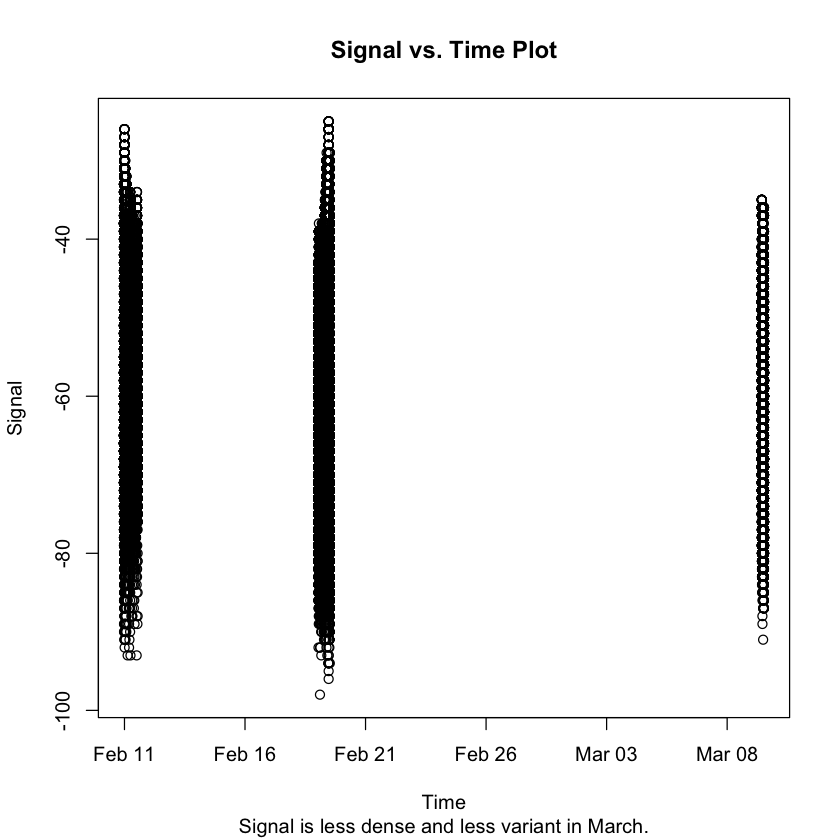

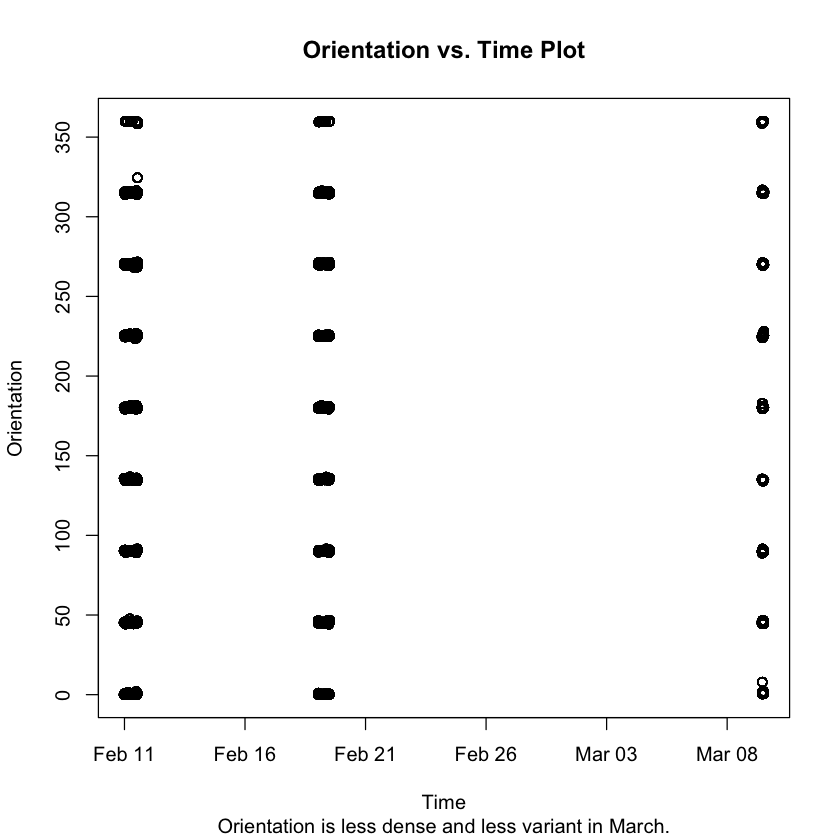

In [383]:
plot(offline$time, offline$signal, xlab="Time", ylab="Signal", 
     main="Signal vs. Time Plot", sub="Signal is less dense and less variant in March.")
plot(offline$time, offline$orientation, xlab="Time", ylab="Orientation", 
     main="Orientation vs. Time Plot", , sub="Orientation is less dense and less variant in March.")


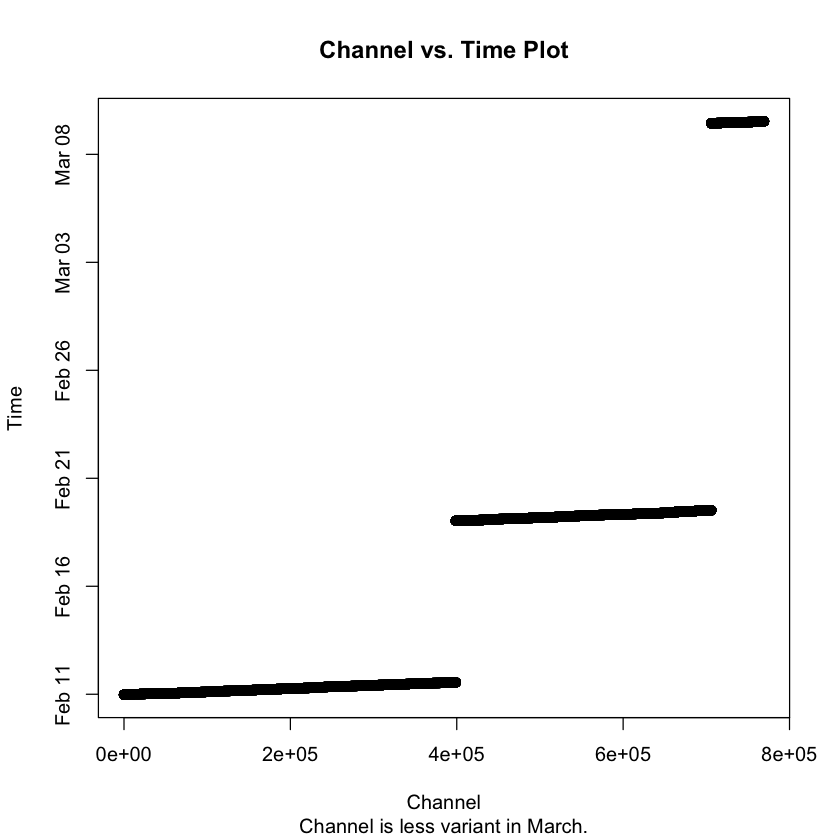

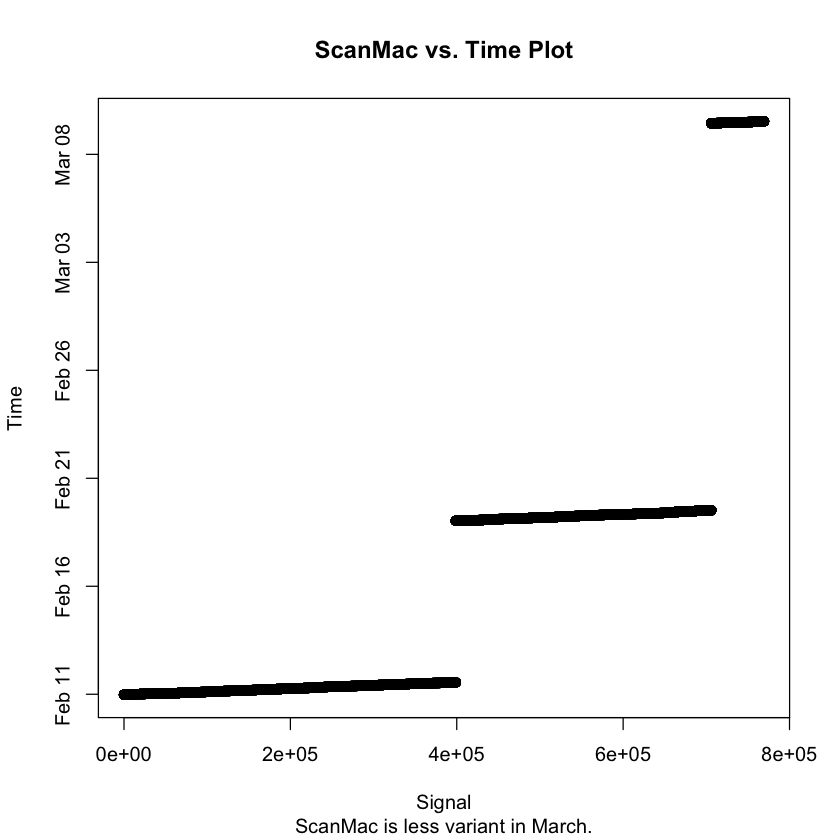

In [427]:
plot(offline$time, offline$channel, ylab="Time", xlab="Channel", 
     main="Channel vs. Time Plot", sub="Channel is less variant in March.")
plot(offline$time, offline$scanMac, xlab="Signal", ylab="Time",
     main="ScanMac vs. Time Plot", sub="ScanMac is less variant in March.")


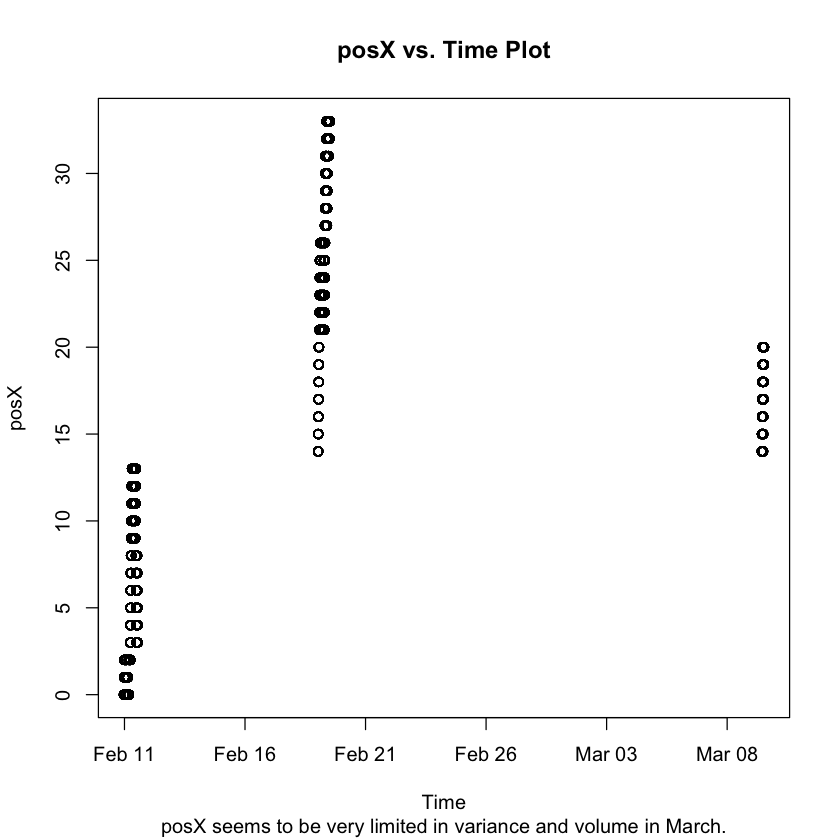

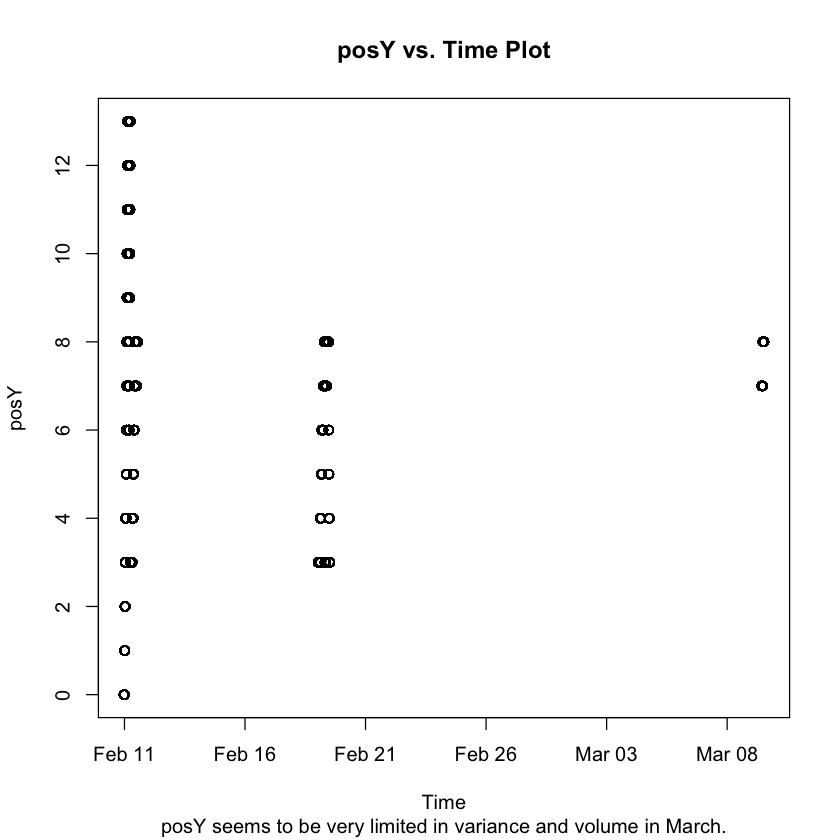

In [385]:
plot(offline$time, offline$posX, ylab="posX", xlab="Time",  
     main="posX vs. Time Plot",
     sub="posX seems to be very limited in variance and volume in March.")
plot(offline$time, offline$posY, ylab="posY", xlab="Time",
     main="posY vs. Time Plot",
     sub="posY seems to be very limited in variance and volume in March.")



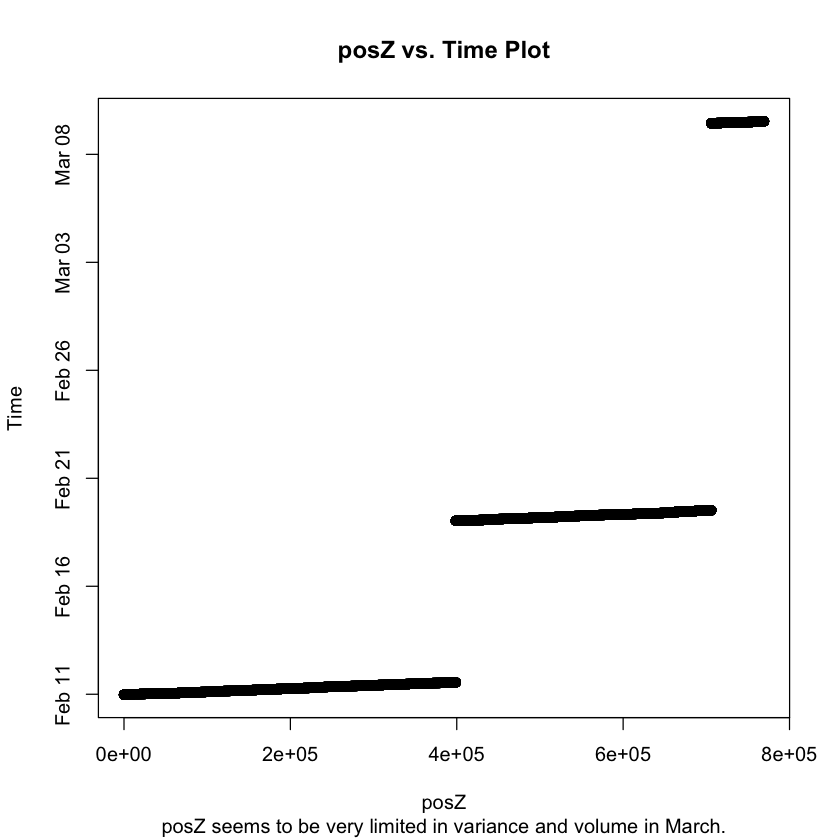

In [428]:
plot(offline$time, offline$posZ, ylab="Time", xlab="posZ",
     main="posZ vs. Time Plot", 
     sub="posZ seems to be very limited in variance and volume in March.")

## Plots of different variables against time

Nolan and Lang left this exercise for us to detect any time related bias in the data as they examined all variables except "time" and "signal". By plotting variable against the time, we observe that data has been captured in three dates in February and March. These plots indicate that we have less data in March compared to February. Channels and orientations are very limited (which may reflect certain behavior of handheld device users in March). Posx, posY and posZ indicate that handheld device users did not show up in different locations (Unlike what we observed in Fig. 1) in March. This may cause a bias in predicting location. We will consider this as part of our analysis.    

null device 
          1

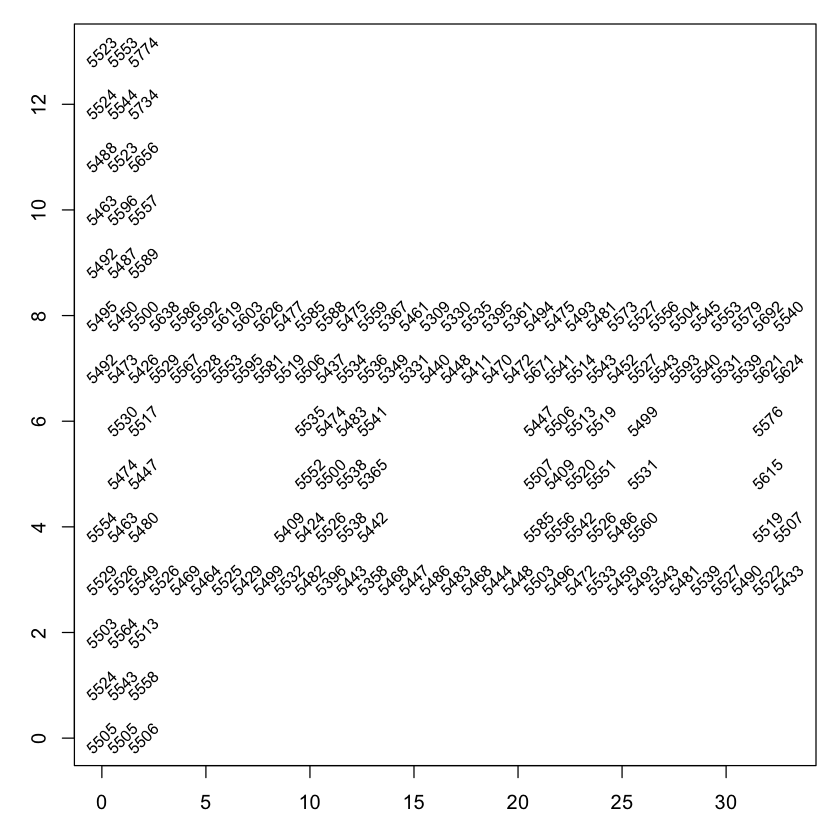

In [387]:
#pdf(file = "Geo_XYByCount.pdf", width = 10)
oldPar = par(mar = c(3.1, 3.1, 1, 1))

locCounts = t(locCounts)
plot(locCounts, type = "n", xlab = "", ylab = "")
text(locCounts, labels = locCounts[,3], cex = .8, srt = 45)


par(oldPar)
dev.off()

## ReadData() Excercise

Now we need to cleanse the signal data now. As explained in Section 1.3.4 of Data Science in R, the following process introduces a function to redo all cleansing we have done in "readData" function. It reuses the roundRotation and processLine functionality that we have globally shared in the R session. Then we use the idential functionality to verify that the output of "readData" function is identical to the existing "offline" variable.

In [388]:
subMacCollection <- c("00:0f:a3:39:e1:c0", "00:0f:a3:39:dd:cd", "00:14:bf:b1:97:8a",
                       "00:14:bf:3b:c7:c6", "00:14:bf:b1:97:90", "00:14:bf:b1:97:8d",
                       "00:14:bf:b1:97:81")
readData = function(filename = 'data/offline.final.trace.txt', subMacs = subMacCollection)
{
    txt = readLines(filename)
    lines = txt[ substr(txt, 1, 1) != "#" ]
    tmp = lapply(lines, processLine)
    offline = as.data.frame(do.call("rbind", tmp), 
                            stringsAsFactors= FALSE) 
    
    names(offline) = c("time", "scanMac", 
                       "posX", "posY", "posZ", "orientation", 
                       "mac", "signal", "channel", "type")
    
     # keep only signals from access points
    offline = offline[ offline$type == "3", ]
    
    # drop scanMac, posZ, channel, and type - no info in them
    dropVars = c("scanMac", "posZ", "channel", "type")
    offline = offline[ , !( names(offline) %in% dropVars ) ]
    
    # drop more unwanted access points
    offline = offline[ offline$mac %in% subMacs, ]
    offline
    # convert numeric values
    numVars = c("time", "posX", "posY", "orientation", "signal")
    offline[ numVars ] = lapply(offline[ numVars ], as.numeric)

    # convert time to POSIX
    offline$rawTime = offline$time
    offline$time = offline$time/1000
    class(offline$time) = c("POSIXt", "POSIXct")
    
    # round orientations to nearest 45
    offline$angle = roundOrientation(offline$orientation)
      
    return(offline)
  }

offlineRedo = readData()

identical(offline, offlineRedo)

[1] TRUE


  We have measured the signal strength to an access point multiple times at each location and orientation. How do these signal strengths behave? That is, what is the distribution of the repeated measurements at each location and orientation? Does signal strength behave similarly at all locations? Or does, the location, orientation, and access point affect this distribution?

 In practice, physical characteristics of a building and human activity can add significant noise to signal strength measurements. How can we characterize the relationship between the signal strength and the distance from the device to the access point? How does the orientation affect this relationship? Is this relationship the same for all access points?

We wil try to find answer for these questions.


#### Distribution of Signal Strength
We want to compare the distribution of signal strength at different orientations and for different access points, so we need to subdivide our data. We are interested in seeing if these distributions are normal or skewed. We also want to look at their variances.

We would like to consider the impact of orientation on signal strength by fixing a location on the map to see how the signal changes as the experimenter rotates through the 8 angles. We also separately examine the MAC addresses because, for example, at an orientation of 90 degrees the experimenter may be facing toward one access point and away from another. As part of the work, we summarize the signal values. The more negative the signal value is, the weaker it becomes. 

null device 
          1

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    -98     -67     -59     -60     -53     -25 

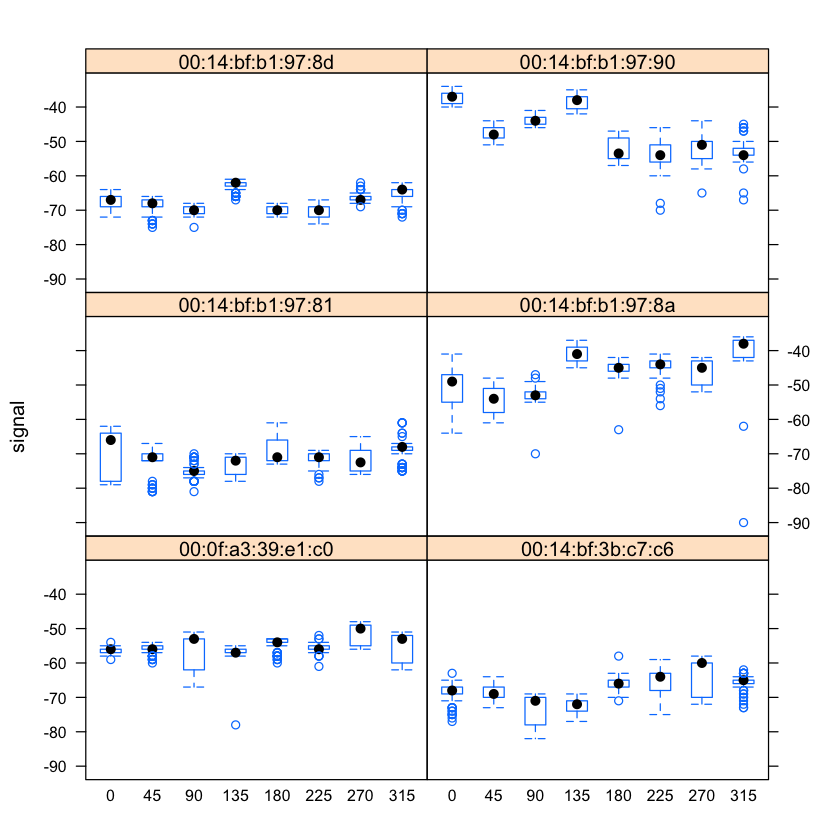

In [389]:
#pdf(file = "Geo_BoxplotSignalByMacAngle.pdf", width = 7)
oldPar = par(mar = c(3.1, 3, 1, 1))

library(lattice)
bwplot(signal ~ factor(angle) | mac, data = offline, 
       subset = posX == 2 & posY == 12 
                & mac != "00:0f:a3:39:dd:cd", 
       layout = c(2,3))

par(oldPar)
dev.off()

summary(offline$signal)



### Mac address and angle correlation
We observe in the previous plot that the signal strength varies with the orientation for both close and distant access points. Note we have dropped the records for the MAC address of 00:0f:a3:39:dd:cd because it is identified as the extra address in the next section.

In the following code, we compare the distributions of signal strength for different angles and MAC addresses at the central location of x = 23 and y = 4. Lack of normal distribution in the following plot illustrates that conditioning on angle and MAC address is warranted. If the distributions were normal, we could conclude that signal can be received from different angles but that does not seem to be the case.

null device 
          1

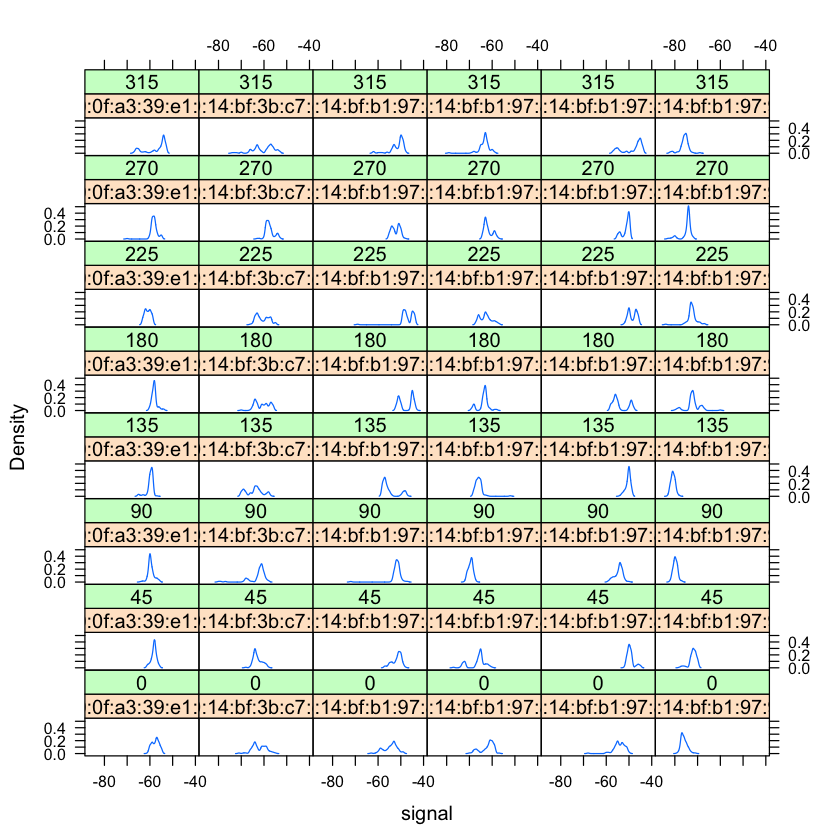

In [390]:
#pdf(file = "Geo_DensitySignalByMacAngle.pdf", width = 8, height = 12)
oldPar = par(mar = c(3.1, 3, 1, 1))

densityplot( ~ signal | mac + factor(angle), data = offline,
             subset = posX == 24 & posY == 4 & 
                         mac != "00:0f:a3:39:dd:cd",
             bw = 0.5, plot.points = FALSE)

par(oldPar)
dev.off()

If we want to examine the distribution of signal strength for all 166 locations, 8 angles, and 6 access points, we need to create thousands of boxplots or density curves. We can, instead, examine summary statistics such as the mean and SD or the median and IQR of signal strength for all location–orientation–access point combinations. For each combination, we have roughly 100 observations. To compute summary statistics for these various combinations, we first create a special factor that contains all of the unique combinations of the observed (x, y) pairs for the 166 locations.

In [391]:
offline$posXY = paste(offline$posX, offline$posY, sep = "-")

byLocAngleAP = with(offline, 
                    by(offline, list(posXY, angle, mac), 
                       function(x) x))

signalSummary = 
  lapply(byLocAngleAP,            
         function(oneLoc) {
           ans = oneLoc[1, ]
           ans$medSignal = median(oneLoc$signal)
           ans$avgSignal = mean(oneLoc$signal)
           ans$num = length(oneLoc$signal)
           ans$sdSignal = sd(oneLoc$signal)
           ans$iqrSignal = IQR(oneLoc$signal)
           ans
           })

offlineSummary = do.call("rbind", signalSummary)                             

We plot the offlineSummary data and observe that the weakest signals have small standard deviations and that it appears that the SD increases with the average signal strength. If we plan to model the behavior of signal strength, then we want to take these features into consideration. The weak signals have low variability and the stronger signals have greater variability.

null device 
          1

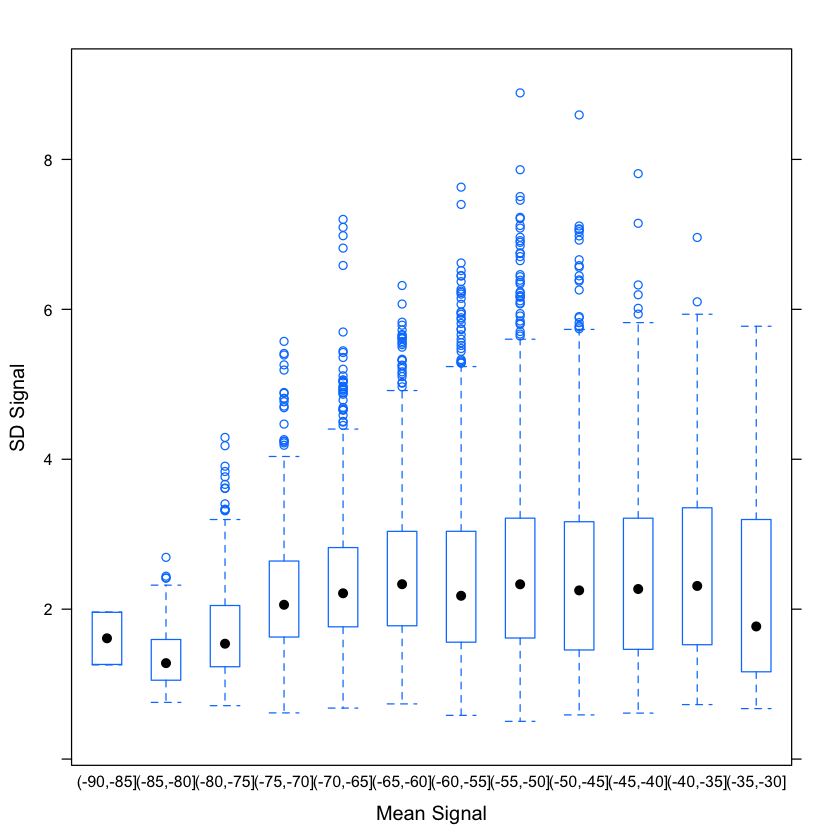

In [392]:
#pdf(file = "Geo_BoxplotSignalSDByAvg.pdf", width = 10)
oldPar = par(mar = c(3.1, 3, 1, 1))

breaks = seq(-90, -30, by = 5)
bwplot(sdSignal ~ cut(avgSignal, breaks = breaks),
       data = offlineSummary, 
       subset = mac != "00:0f:a3:39:dd:cd",
       xlab = "Mean Signal", ylab = "SD Signal")

par(oldPar)
dev.off()

We examine the skewness of signal strength by plotting the difference, avgSignal - medSignal, against the number of observations. Then we use the fitted model to predict the difference for each value of num and add these predictions to the scatter plot. We see that these two measures of centrality are similar to each other; they typically differ by less than 1 to 2 dBm.

null device 
          1

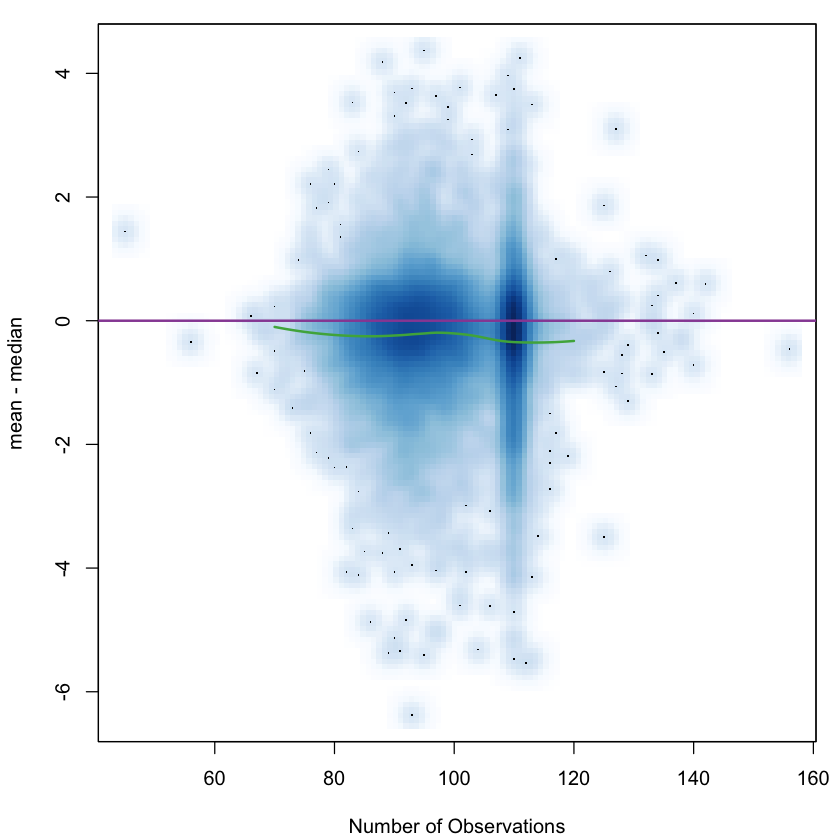

In [393]:
#pdf(file = "Geo_ScatterMean-Median.pdf", width = 10)
oldPar = par(mar = c(4.1, 4.1, 1, 1))

with(offlineSummary,
     smoothScatter((avgSignal - medSignal) ~ num,
                   xlab = "Number of Observations", 
                   ylab = "mean - median"))
abline(h = 0, col = "#984ea3", lwd = 2)

lo.obj = 
  with(offlineSummary,
       loess(diff ~ num, 
             data = data.frame(diff = (avgSignal - medSignal),
                               num = num)))

lo.obj.pr = predict(lo.obj, newdata = data.frame(num = (70:120)))
lines(x = 70:120, y = lo.obj.pr, col = "#4daf4a", lwd = 2)

par(oldPar)
dev.off()
 
oneAPAngle = subset(offlineSummary, 
                    mac == subMacs[5] & angle == 0)

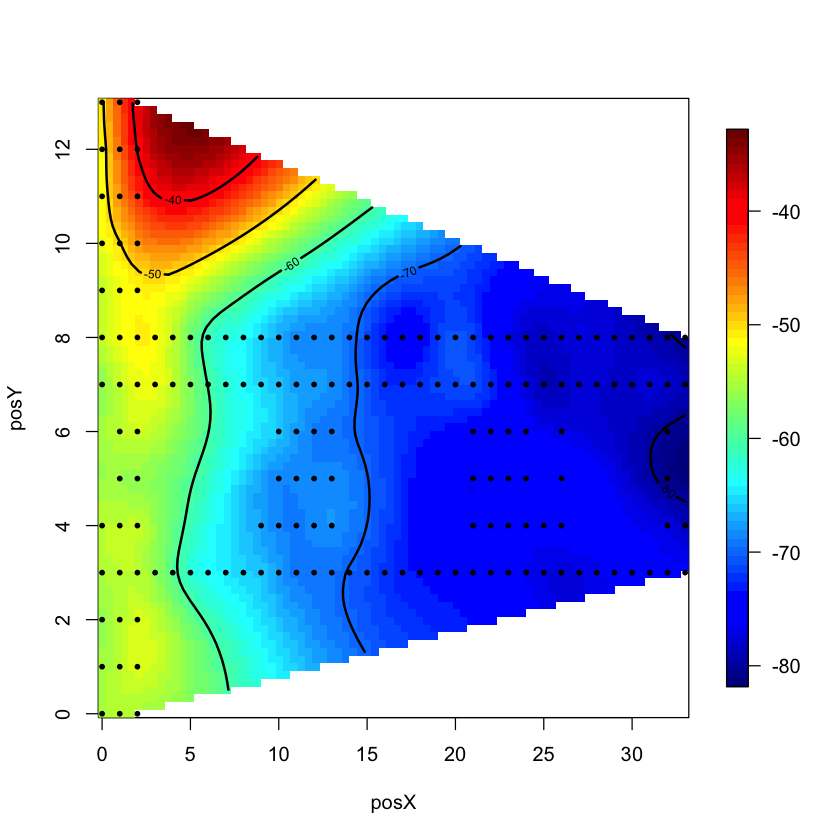

In [394]:
list.of.packages <- c("fields")
new.packages <- list.of.packages[!(list.of.packages %in% installed.packages()[,"Package"])]
if(length(new.packages)) install.packages(new.packages)


library(fields)
smoothSS = Tps(oneAPAngle[, c("posX","posY")], 
               oneAPAngle$avgSignal)

vizSmooth = predictSurface(smoothSS)

plot.surface(vizSmooth, type = "C")

points(oneAPAngle$posX, oneAPAngle$posY, pch=19, cex = 0.5)



we observe that we can easily identify the location of the access point as the dark red region at the top of the “mountain.” We also confirm the effect of the orientation on signal strength. Additionally, a corridor effect emerges. 

The signal is stronger relative to distance along the corridors where the signals are not blocked by walls.
We know the locations of the access points based on the floor plan of the building, but we have not been given their exact location and we do not know the mapping between MAC address and access point. Fortunately, the contour maps that we just created make it easy to connect the MAC address to the access point marked on the floor plan in figure 1.1.

For example, the signals appearing in the top row of the plot clearly correspond to the access point in the top left corner of the building. Also, according to the documentation, the training data were measured at 1 meter intervals in the building so we can use the grey dots on the plan to estimate the location of the access points. We find that two MAC addresses have similar heat maps and these both correspond to the access point near the center of the building (i.e., x = 7.5 and y = 6.3). 

In [395]:
unique(offlineSummary$mac)

[1] "00:0f:a3:39:dd:cd" "00:0f:a3:39:e1:c0" "00:14:bf:3b:c7:c6"
[4] "00:14:bf:b1:97:81" "00:14:bf:b1:97:8a" "00:14:bf:b1:97:8d"
[7] "00:14:bf:b1:97:90"

$`00:14:bf:b1:97:90`
NULL

$`00:14:bf:b1:97:90`
NULL

$`00:0f:a3:39:e1:c0`
NULL

$`00:0f:a3:39:e1:c0`
NULL

,x,y
00:0f:a3:39:e1:c0,7.5,6.3
00:14:bf:b1:97:8a,2.5,-0.8
00:14:bf:3b:c7:c6,12.8,-2.8
00:14:bf:b1:97:90,1.0,14.0
00:14:bf:b1:97:8d,33.5,9.3
00:14:bf:b1:97:81,33.5,2.8


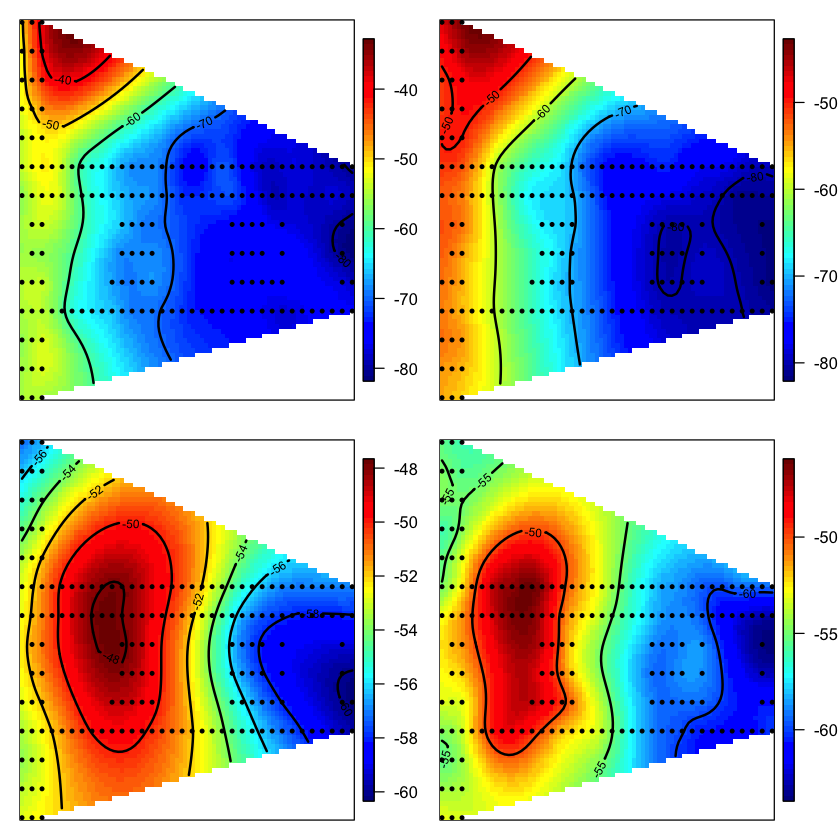

In [396]:
surfaceSS = function(data, mac, angle = 45) {
  require(fields)
  oneAPAngle = data[ data$mac == mac & data$angle == angle, ]
  smoothSS = Tps(oneAPAngle[, c("posX","posY")], 
                 oneAPAngle$avgSignal)
  vizSmooth = predictSurface(smoothSS)
  plot.surface(vizSmooth, type = "C", 
               xlab = "", ylab = "", xaxt = "n", yaxt = "n")
  points(oneAPAngle$posX, oneAPAngle$posY, pch=19, cex = 0.5) 
}

 parCur = par(mfrow = c(2,2), mar = rep(1, 4))

 mapply(surfaceSS, mac = subMacs[ rep(c(5, 1), each = 2) ], 
        angle = rep(c(0, 135), 2),
        data = list(data = offlineSummary))
 
 par(parCur)

 offlineSummary = subset(offlineSummary, mac != subMacs[2])

AP = matrix( c( 7.5, 6.3, 2.5, -.8, 12.8, -2.8,  
                1, 14, 33.5, 9.3,  33.5, 2.8),
            ncol = 2, byrow = TRUE,
            dimnames = list(subMacs[ -2 ], c("x", "y") ))

   AP

## Exercise
Due to heat map similiarity, one of the Mac addresses that is located at the center of the building is removed from the dataset. This decision will have an impact on location prediction. Although it seems that there is a multicolinearity between two Mac addresses and the strength of the signal, the prediction model might have other influencing factors and missing data of a particular location might bias the model in a certain way. We should compute the accuracy of the model, with the first, second and both Mac addresses separately.  

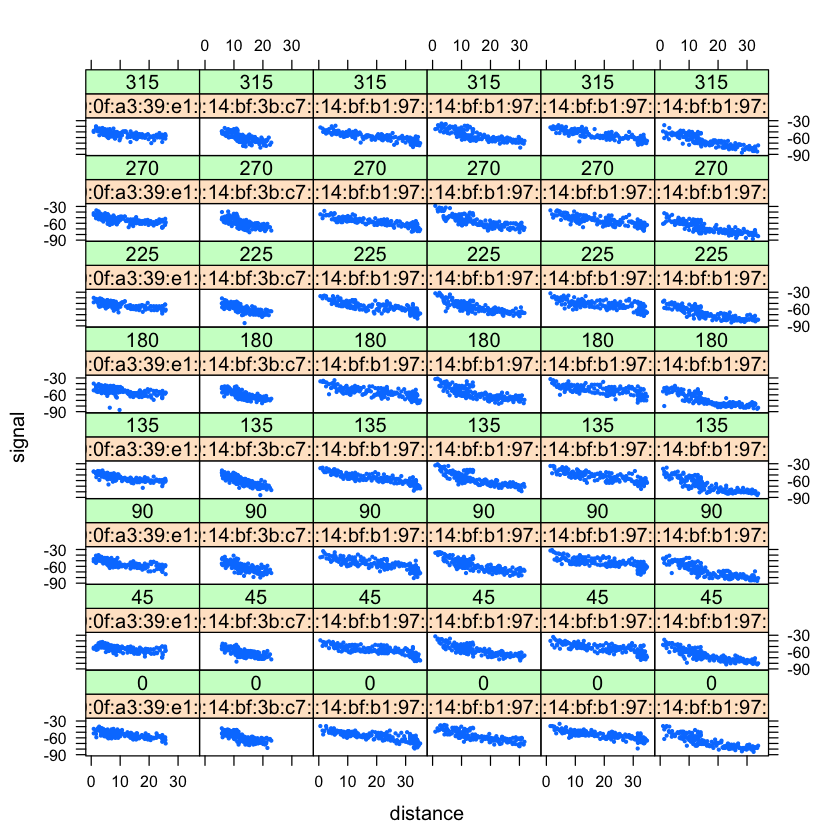

null device 
          1

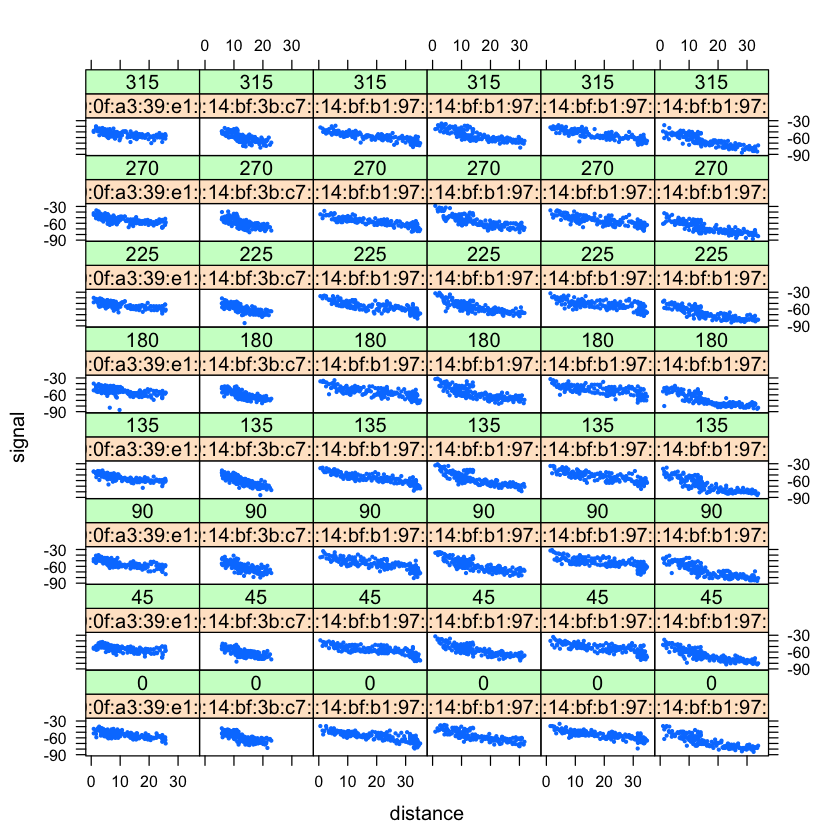

In [397]:
diffs = offlineSummary[ , c("posX", "posY")] - 
          AP[ offlineSummary$mac, ]

offlineSummary$dist = sqrt(diffs[ , 1]^2 + diffs[ , 2]^2)

xyplot(signal ~ dist | factor(mac) + factor(angle), 
       data = offlineSummary, pch = 19, cex = 0.3,
       xlab ="distance")

#pdf(file="Geo_ScatterSignalDist.pdf", width = 7, height = 10)
oldPar = par(mar = c(3.1, 3.1, 1, 1))
library(lattice)
xyplot(signal ~ dist | factor(mac) + factor(angle), 
       data = offlineSummary, pch = 19, cex = 0.3,
       xlab ="distance")
par(oldPar)
dev.off()

macs = unique(offlineSummary$mac)

## Log transformation Exercise
As there appears to be a curvature in the above plots, Nolan and Lang suggest that we do a log transformation. We initially did the log transformation and it did not work. So we used the following summary functions to figure out how the data should be shifted. 


In [398]:
summary(offlineSummary$signal)
summary(offlineSummary$dist)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    -88     -64     -58     -58     -52     -29 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
      1       9      14      16      23      35 

The above numbers taught us that we should at least add the data 89 to avoid negative values. As illustrated below, the log transformation was succesfull and the curvature almost disappeared. Then we decided to add logSignal and logDist to the offlineSummary. If we use it in the model later, we should remember to reverse log transformation in the conclusion phase.

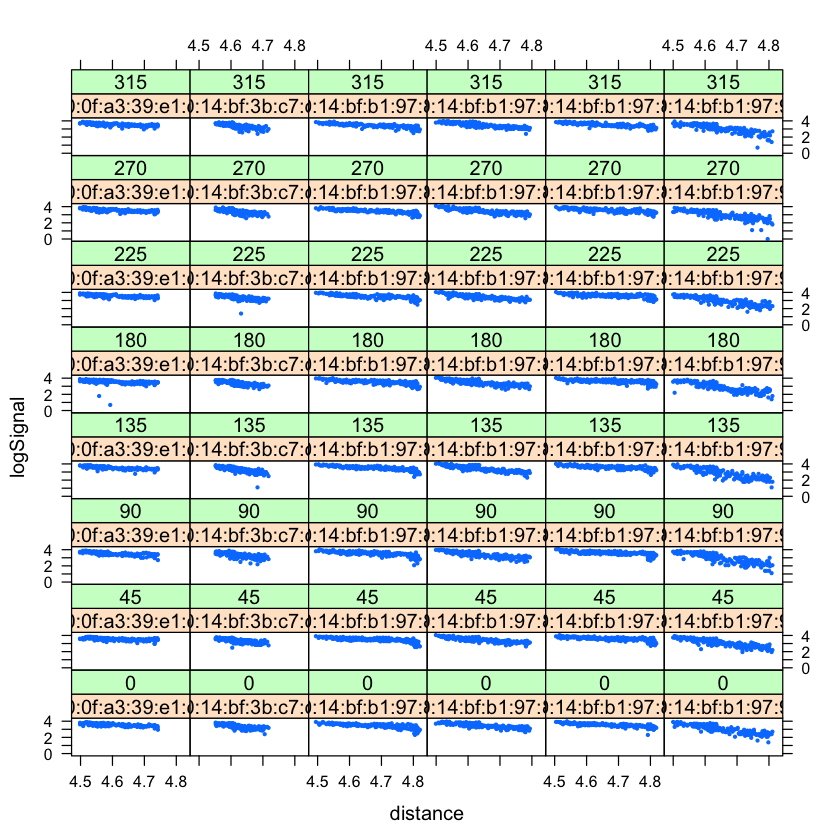

null device 
          1

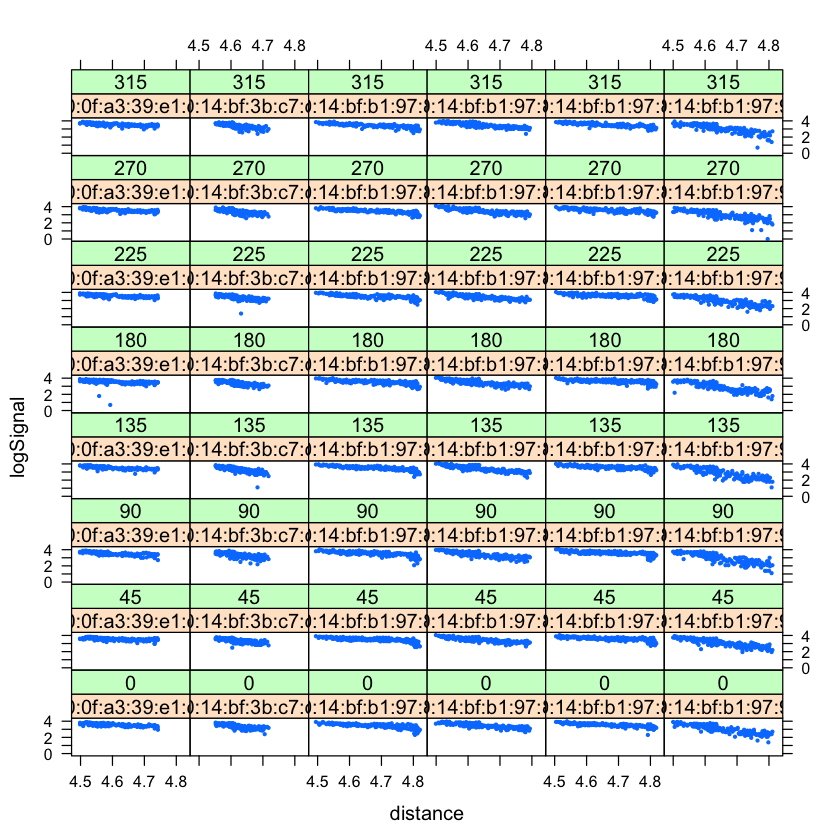

In [399]:
offset <- 89
logSignal <- log(offlineSummary$signal + offset)
logDist <- log(offlineSummary$dist + offset)
xyplot(logSignal ~ logDist| factor(mac) + factor(angle), 
       data = offlineSummary, pch = 19, cex = 0.3,
       xlab ="logDistance")

#pdf(file="Geo_ScatterSignalDist.pdf", width = 7, height = 10)
oldPar = par(mar = c(3.1, 3.1, 1, 1))
library(lattice)
xyplot(logSignal ~ logDist | factor(mac) + factor(angle), 
       data = offlineSummary, pch = 19, cex = 0.3,
       xlab ="logDistance")
par(oldPar)
dev.off()

offlineSummary$logSignal = logSignal
offlineSummary$logDist = logDist
macs = unique(offlineSummary$mac)

 At this point, we have a set of training data that we can use to predict the location of our new point. We want to look at the distance in terms of signal strengths from these training data to the new point. If we would like to use the nearest neighbor or the 3 nearest neighbors, we need to calculate the distance from the new point to all observations in the training set.
 The following code prepares the test data by talling the number of signal strengths recorded at each location, keeping the data variables that is being used in assessing prediction. This new data frame will have 60 rows and 11 variables, including 6 average signal strengths at the corresponding MAC addresses. The dimension of onlineSummary will verify the result. 

In [400]:
online = readData("data/online.final.trace.txt", subMacs = macs)

online$posXY = paste(online$posX, online$posY, sep = "-")

length(unique(online$posXY))

tabonlineXYA = table(online$posXY, online$angle)
tabonlineXYA[1:6, ]

keepVars = c("posXY", "posX","posY", "orientation", "angle")
byLoc = with(online, 
             by(online, list(posXY), 
                function(x) {
                  ans = x[1, keepVars]
                  avgSS = tapply(x$signal, x$mac, mean)
                  y = matrix(avgSS, nrow = 1, ncol = 6,
                        dimnames = list(ans$posXY, names(avgSS)))
                  cbind(ans, y)
                }))

onlineSummary = do.call("rbind", byLoc) 

Warning message in readLines(filename):
“ligne finale incomplète trouvée dans 'data/online.final.trace.txt'”

[1] 60

            
               0  45  90 135 180 225 270 315
  0-0.05       0   0   0 593   0   0   0   0
  0.15-9.42    0   0 606   0   0   0   0   0
  0.31-11.09   0   0   0   0   0 573   0   0
  0.47-8.2   590   0   0   0   0   0   0   0
  0.78-10.94 586   0   0   0   0   0   0   0
  0.93-11.69   0   0   0   0 583   0   0   0

In the nearest neighbor model, we would like to find records in our offline data that have similiar orientations to our new observation as orientation can impact the strength of the signal. That is why we consider using all records with an orientation that is within a specified range of the new point's orientation. 

Since the observations were recorded in 45 degree increments, we can simply specify the number of neighboring angles to include from the training data. For example, if we want only one orientation, then we only include training data with angles that match the rounded orientation value of the new observation. If we want two orientations then we pick those two multiples of 45 degrees that flank the new observation’s orientation; for three, we choose the closest 45 degree increment and one on either side of it, and so on.

The following code that will later be used in selectTrain function will help us enable the choice of orientation. 

In [401]:
dim(onlineSummary)

names(onlineSummary)
m = 3; angleNewObs = 230
refs = seq(0, by = 45, length  = 8)
nearestAngle = roundOrientation(angleNewObs)
  
if (m %% 2 == 1) {
  angles = seq(-45 * (m - 1) /2, 45 * (m - 1) /2, length = m)
} else {
  m = m + 1
  angles = seq(-45 * (m - 1) /2, 45 * (m - 1) /2, length = m)
  if (sign(angleNewObs - nearestAngle) > -1) 
    angles = angles[ -1 ]
  else 
    angles = angles[ -m ]
}
angles = angles + nearestAngle
angles[angles < 0] = angles[ angles < 0 ] + 360
angles[angles > 360] = angles[ angles > 360 ] - 360

[1] 60 11

[1] "posXY"             "posX"              "posY"             
 [4] "orientation"       "angle"             "00:0f:a3:39:e1:c0"
 [7] "00:14:bf:3b:c7:c6" "00:14:bf:b1:97:81" "00:14:bf:b1:97:8a"
[10] "00:14:bf:b1:97:8d" "00:14:bf:b1:97:90"

The following code introduces a reshapeSS function that aggregates the signal strengths for the angles. Then we will summarize and reshape "offlineSubset" data in trainSS variable.  

In [402]:
offlineSubset = 
  offlineSummary[ offlineSummary$angle %in% angles, ]

reshapeSS = function(data, varSignal = "signal", 
                     keepVars = c("posXY", "posX","posY")) {
  byLocation =
    with(data, by(data, list(posXY), 
                  function(x) {
                    ans = x[1, keepVars]
                    avgSS = tapply(x[ , varSignal ], x$mac, mean)
                    y = matrix(avgSS, nrow = 1, ncol = 6,
                               dimnames = list(ans$posXY,
                                               names(avgSS)))
                    cbind(ans, y)
                  }))

  newDataSS = do.call("rbind", byLocation)
  return(newDataSS)
}

trainSS = reshapeSS(offlineSubset, varSignal = "avgSignal")

## selectTrain() Exercise
The following code reuses the above functionality to enable the choice of orientation and aggregate the signal strengths for the angles. It averages the signal strength for different angles to produce one set of signal stengths for each of the 166 locations in the training data.

In [403]:
selectTrain = function(angleNewObs, signals = NULL, m = 1){
  # m is the number of angles to keep between 1 and 5
  refs = seq(0, by = 45, length  = 8)
  nearestAngle = roundOrientation(angleNewObs)
  
  if (m %% 2 == 1) 
    angles = seq(-45 * (m - 1) /2, 45 * (m - 1) /2, length = m)
  else {
    m = m + 1
    angles = seq(-45 * (m - 1) /2, 45 * (m - 1) /2, length = m)
    if (sign(angleNewObs - nearestAngle) > -1) 
      angles = angles[ -1 ]
    else 
      angles = angles[ -m ]
  }
  angles = angles + nearestAngle
  angles[angles < 0] = angles[ angles < 0 ] + 360
  angles[angles > 360] = angles[ angles > 360 ] - 360
  angles = sort(angles) 
  
  offlineSubset = signals[ signals$angle %in% angles, ]
  reshapeSS(offlineSubset, varSignal = "avgSignal")
}

train130 = selectTrain(130, offlineSummary, m = 3)

head(train130)

length(train130[[1]])

,posXY,posX,posY,00:0f:a3:39:e1:c0,00:14:bf:3b:c7:c6,00:14:bf:b1:97:81,00:14:bf:b1:97:8a,00:14:bf:b1:97:8d,00:14:bf:b1:97:90
0-0,0-0,0,0,-52,-66,-63,-36,-64,-55
0-1,0-1,0,1,-53,-65,-64,-39,-65,-59
0-10,0-10,0,10,-56,-66,-69,-45,-67,-50
0-11,0-11,0,11,-55,-67,-70,-48,-67,-55
0-12,0-12,0,12,-56,-70,-72,-45,-67,-50
0-13,0-13,0,13,-55,-71,-73,-43,-69,-54


[1] 166

We now have a set of training data that we can use to predict the location of our new point. We want to look at the distance in terms of signal stength from these training data to the new point. So we need to calculate the distance from the new point to all observations in the training set. The findNN function will help us to do the calculation. It will return the locations of the training observations in order of closeness to the new observation's singal strength.  Later, you will see that a subset of this result can be used to estimate the location of the new observation(For k value of nearest neighbors, we can simply average the first k locations).

In [404]:

findNN = function(newSignal, trainSubset) {
  diffs = apply(trainSubset[ , 4:9], 1, 
                function(x) x - newSignal)
  dists = apply(diffs, 2, function(x) sqrt(sum(x^2)) )
  closest = order(dists)
  return(trainSubset[closest, 1:3])
}

The following function can predict the location for all dataset by reusing trainSelect and findNN functions.
Please consider that we calculate the average of k neighbor distance using anonymous function using Euclidean distance. This function can later be imporved to be passed as a parameter to calculate the predicted location.

The "predXY" is then invoked using 1 and 3 nearest neighbors and 3 orientations. We will later calculate the accuracy of our predictions with different number of neighbors.

In [405]:
predXY = function(newSignals, newAngles, trainData, numAngles = 1, k = 3) {
  
  closeXY = list(length = nrow(newSignals))
  
  for (i in 1:nrow(newSignals)) {
    trainSS = selectTrain(newAngles[i], trainData, m = numAngles)
    closeXY[[i]] = 
      findNN(newSignal = as.numeric(newSignals[i, ]), trainSS)
  }

  estXY = lapply(closeXY, 
                 function(x) sapply(x[ , 2:3], 
                                    function(x) mean(x[1:k])))
  estXY = do.call("rbind", estXY)
  return(estXY)
}
estXYk3 = predXY(newSignals = onlineSummary[ , 6:11], 
                 newAngles = onlineSummary[ , 4], 
                 offlineSummary, numAngles = 3, k = 3)
                                    

estXYk1 = predXY(newSignals = onlineSummary[ , 6:11], 
                 newAngles = onlineSummary[ , 4], 
                 offlineSummary, numAngles = 3, k = 1)



## Plotting the errors
The following function plots the errors for the predicated locations using different nearest neighbor numbers.

In [406]:
floorErrorMap = function(estXY, actualXY, trainPoints = NULL, AP = NULL) {
  
    plot(0, 0, xlim = c(0, 35), ylim = c(-3, 15), type = "n",
         xlab = "", ylab = "", axes = FALSE)
    box()
    if ( !is.null(AP) ) points(AP, pch = 15)
    if ( !is.null(trainPoints) )
      points(trainPoints, pch = 19, col="grey", cex = 0.6)
    
    points(x = actualXY[, 1], y = actualXY[, 2], 
           pch = 19, cex = 0.8 )
    points(x = estXY[, 1], y = estXY[, 2], 
           pch = 8, cex = 0.8 )
    segments(x0 = estXY[, 1], y0 = estXY[, 2],
             x1 = actualXY[, 1], y1 = actualXY[ , 2],
             lwd = 2, col = "red")
}

trainPoints = offlineSummary[ offlineSummary$angle == 0 & 
                              offlineSummary$mac == "00:0f:a3:39:e1:c0" ,
                        c("posX", "posY")]

null device 
          1

null device 
          1

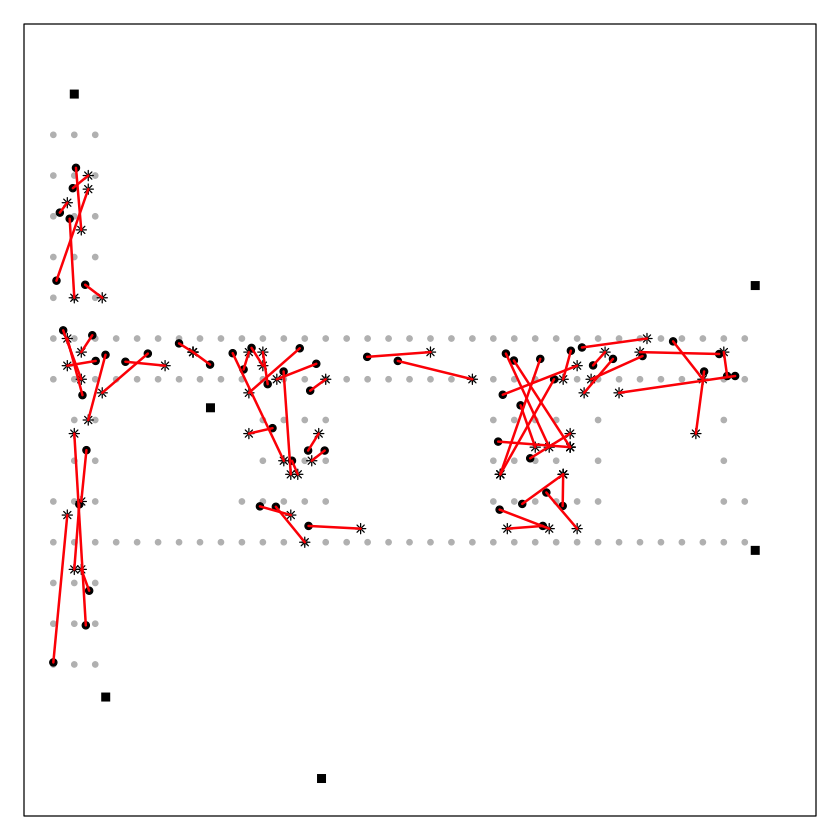

In [407]:
#pdf(file="GEO_FloorPlanK3Errors.pdf", width = 10, height = 7)
oldPar = par(mar = c(1, 1, 1, 1))
floorErrorMap(estXYk3, onlineSummary[ , c("posX","posY")], 
              trainPoints = trainPoints, AP = AP)
par(oldPar)
dev.off()

#pdf(file="GEO_FloorPlanK1Errors.pdf", width = 10, height = 7)
oldPar = par(mar = c(1, 1, 1, 1))
floorErrorMap(estXYk1, onlineSummary[ , c("posX","posY")], 
              trainPoints = trainPoints, AP = AP)
par(oldPar)
dev.off()



## Root Mean Square Error
While the above code visualizes the error, the calcError function calculates the root mean square error. The following result represents larger numbers compared to our previous calculations. This indicates that the root mean square error of the predicted result with 3 nearest neighbor is considerably more accurate. But we might still do better with different number of nearest neighbors.

In [408]:
calcError = 
function(estXY, actualXY) 
   sum( rowSums( (estXY - actualXY)^2) )

actualXY = onlineSummary[ , c("posX", "posY")]
sapply(list(estXYk1, estXYk3), calcError, actualXY)

[1] 659 307

If we create v fold of subset of offline data as test data and use a subset of corresponding online data, we can find the K-NN estimate for a large K number for a certain number of angles with average signal strength. This will help us avoid overfitting. The following code help us to create the essential subset data with v =11 to create roughly equal folds across. 

In [409]:
v = 11
permuteLocs = sample(unique(offlineSummary$posXY))
permuteLocs = matrix(permuteLocs, ncol = v, 
                     nrow = floor(length(permuteLocs)/v))

onlineFold = subset(offlineSummary, posXY %in% permuteLocs[ , 1])

reshapeSS = function(data, varSignal = "signal", 
                     keepVars = c("posXY", "posX","posY"),
                     sampleAngle = FALSE, 
                     refs = seq(0, 315, by = 45)) {
  byLocation =
    with(data, by(data, list(posXY), 
                  function(x) {
                    if (sampleAngle) {
                      x = x[x$angle == sample(refs, size = 1), ]}
                    ans = x[1, keepVars]
                    avgSS = tapply(x[ , varSignal ], x$mac, mean)
                    y = matrix(avgSS, nrow = 1, ncol = 6,
                               dimnames = list(ans$posXY,
                                               names(avgSS)))
                    cbind(ans, y)
                  }))

  newDataSS = do.call("rbind", byLocation)
  return(newDataSS)
}

Warning message in matrix(permuteLocs, ncol = v, nrow = floor(length(permuteLocs)/v)):
“la longueur des données [166] n'est pas un diviseur ni un multiple du nombre de lignes [15]”

Using "reshapeSS" function, we will prepare the offline vs. online data and predict the result in "estFold" for 3 neighbors and 3 angles. Now we are ready to calculate the error. 

In [410]:
offline = offline[ offline$mac != "00:0f:a3:39:dd:cd", ]

keepVars = c("posXY", "posX","posY", "orientation", "angle")

onlineCVSummary = reshapeSS(offline, keepVars = keepVars, 
                            sampleAngle = TRUE)

onlineFold = subset(onlineCVSummary, 
                    posXY %in% permuteLocs[ , 1])

offlineFold = subset(offlineSummary,
                     posXY %in% permuteLocs[ , -1])

estFold = predXY(newSignals = onlineFold[ , 6:11], 
                 newAngles = onlineFold[ , 4], 
                 offlineFold, numAngles = 3, k = 3)

Now we predict the result with different number of (k) neighbors, and calculate the error size per scenario. This data will help us find the best possible K using a brute force approach and as we hope the cross validation reduces the chance of overfitting. 

## What to expect
Before running the plot, we expect that the estimate of many sensors that are far away from each other will not lead to accurate location. That is why a small K is expected to have the minimum root mean square error.   

In [411]:
actualFold = onlineFold[ , c("posX", "posY")]
calcError(estFold, actualFold)

K = 20
err = rep(0, K)

for (j in 1:v) {
  onlineFold = subset(onlineCVSummary, 
                      posXY %in% permuteLocs[ , j])
  offlineFold = subset(offlineSummary,
                       posXY %in% permuteLocs[ , -j])
  actualFold = onlineFold[ , c("posX", "posY")]
  
  for (k in 1:K) {
    estFold = predXY(newSignals = onlineFold[ , 6:11],
                     newAngles = onlineFold[ , 4], 
                     offlineFold, numAngles = 3, k = k)
    err[k] = err[k] + calcError(estFold, actualFold)
  }
}

[1] 38

The following code will plot the error data per predicted location for each fold. We observe that root mean square error is minimized for k = 10 which stand somewhere between 1 and 20. As expected, the error rate will increase with too many neighbors (K > 10) contributing to the calculation of the location. We also observe that the calculation of one or two sensors leads to inaccurate results, but as closest neighbors contribute more to the calculation, the rate of error drastically decrease. 

## What we learn from this observation
This observation proves that although KNN does not scale very well due to its complexity O(N^2), it yeilds tangible results for problems with relatively small input.   

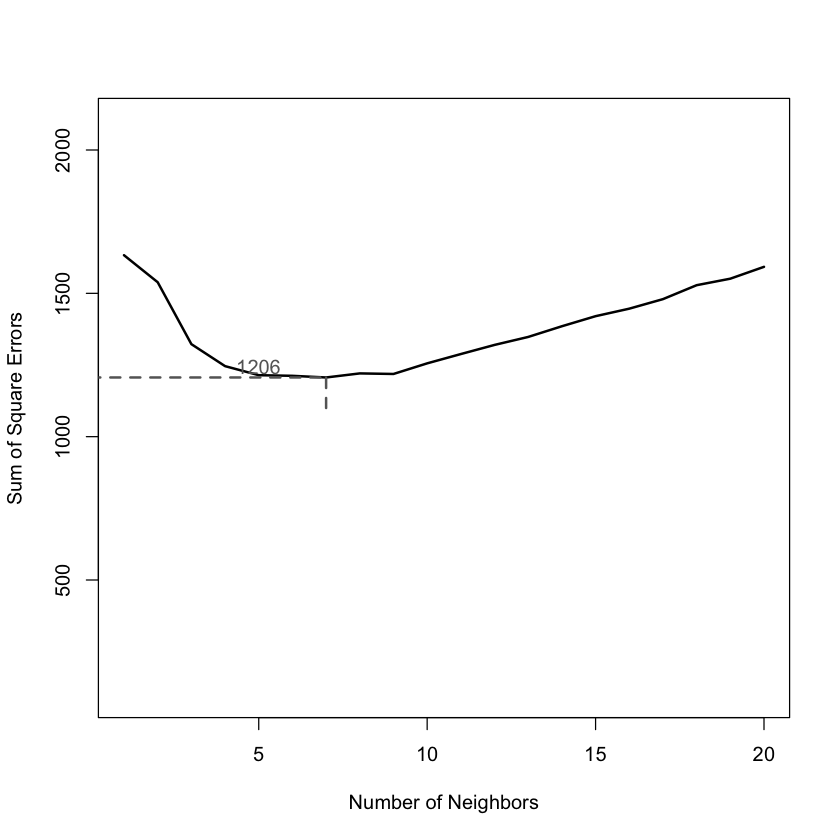

In [412]:
#pdf(file = "Geo_CVChoiceOfK.pdf", width = 10, height = 6)
#oldPar = par(mar = c(4, 3, 1, 1))
plot(y = err, x = (1:K),  type = "l", lwd= 2,
     ylim = c(100, 2100),
     xlab = "Number of Neighbors",
     ylab = "Sum of Square Errors")

rmseMin = min(err)
kMin = which(err == rmseMin)[1]
segments(x0 = 0, x1 = kMin, y0 = rmseMin, col = gray(0.4), 
         lty = 2, lwd = 2)
segments(x0 = kMin, x1 = kMin, y0 = 1100,  y1 = rmseMin, 
         col = grey(0.4), lty = 2, lwd = 2)
text(x = kMin - 2, y = rmseMin + 40, 
     label = as.character(round(rmseMin)), col = grey(0.4))
#par(oldPar)
#dev.off()

In [413]:
#mtext(kMin, side = 1, line = 1, at = kMin, col = grey(0.4))


estXYk5 = predXY(newSignals = onlineSummary[ , 6:11], 
                 newAngles = onlineSummary[ , 4], 
                 offlineSummary, numAngles = 3, k = 5)

calcError(estXYk5, actualXY)

[1] 276

In [414]:
predXY = function(newSignals, newAngles, trainData, 
                  numAngles = 1, k = 3){
  
  closeXY = list(length = nrow(newSignals))
  
  for (i in 1:nrow(newSignals)) {
    trainSS = selectTrain(newAngles[i], trainData, m = numAngles)
    closeXY[[i]] = findNN(newSignal = as.numeric(newSignals[i, ]),
                           trainSS)
  }

  estXY = lapply(closeXY, function(x)
                            sapply(x[ , 2:3], 
                                    function(x) mean(x[1:k])))
  estXY = do.call("rbind", estXY)
  return(estXY)
}

## Question
Conduct a more thorough data analysis into these two MAC addresses including determining locations by using data corresponding to both MAC addresses(with MAC address "00:0f:a3:39:e1:c0" and "00:0f:a3:39:dd:cd").  Which of these two MAC addresses should be used and which should not be used for RTLS? 



## Access Point data Analysis
The following code prints the number of existing data for "00:0f:a3:39:e1:c0" and "00:0f:a3:39:dd:cd" access points. We observe that the size of the data is very close. Plotting the data of both access points indicates that "00:0f:a3:39:dd:cd" data has lower signal strength, and we know that the signal strength has an impact on the location prediction.    



null device 
          1


00:0f:a3:39:dd:cd 00:0f:a3:39:e1:c0 
           145619            145862 

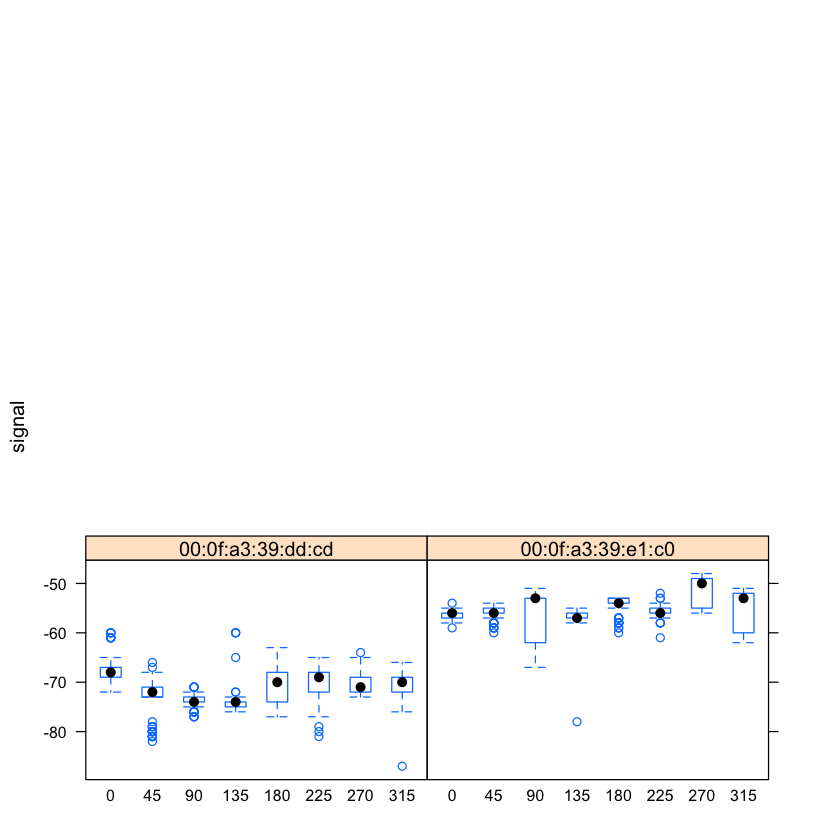

In [415]:
comparedAccessPoints = c("00:0f:a3:39:e1:c0", "00:0f:a3:39:dd:cd")
originalOffline = readData(subMacs = comparedAccessPoints)
oldPar = par(mar = c(3.1, 3, 1, 1))

library(lattice)
bwplot(signal ~ factor(angle) | mac, data = originalOffline, 
       subset = posX == 2 & posY == 12, 
       layout = c(2,3))

par(oldPar)
dev.off()

table(originalOffline$mac)
subMacs = names(sort(table(originalOffline$mac), decreasing = TRUE))[1:7]

## Analysis
Nolan and Temple Lang did not use one of the seven access points that exists in the offline data set. The access point "00:0f:a3:39:dd:cd" was removed by them in the analysis as it was roughly in the same location as "00:0f:a3:39:e1:c0". 
We will rerun all the steps again with "00:0f:a3:39:dd:cd" and without "00:0f:a3:39:e1:c0". We will observe the results with the requested access points data. Then we will do KNN with both data in the model and compare the root mean square error between predicted and actual locations. 

null device 
          1

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    -98     -69     -61     -61     -54     -25 

null device 
          1

null device 
          1

null device 
          1

[1] "00:0f:a3:39:dd:cd" "00:14:bf:3b:c7:c6" "00:14:bf:b1:97:81"
[4] "00:14:bf:b1:97:8a" "00:14:bf:b1:97:8d" "00:14:bf:b1:97:90"

$`00:14:bf:b1:97:8d`
NULL

$`00:14:bf:b1:97:8d`
NULL

$`00:14:bf:b1:97:8a`
NULL

$`00:14:bf:b1:97:8a`
NULL

null device 
          1

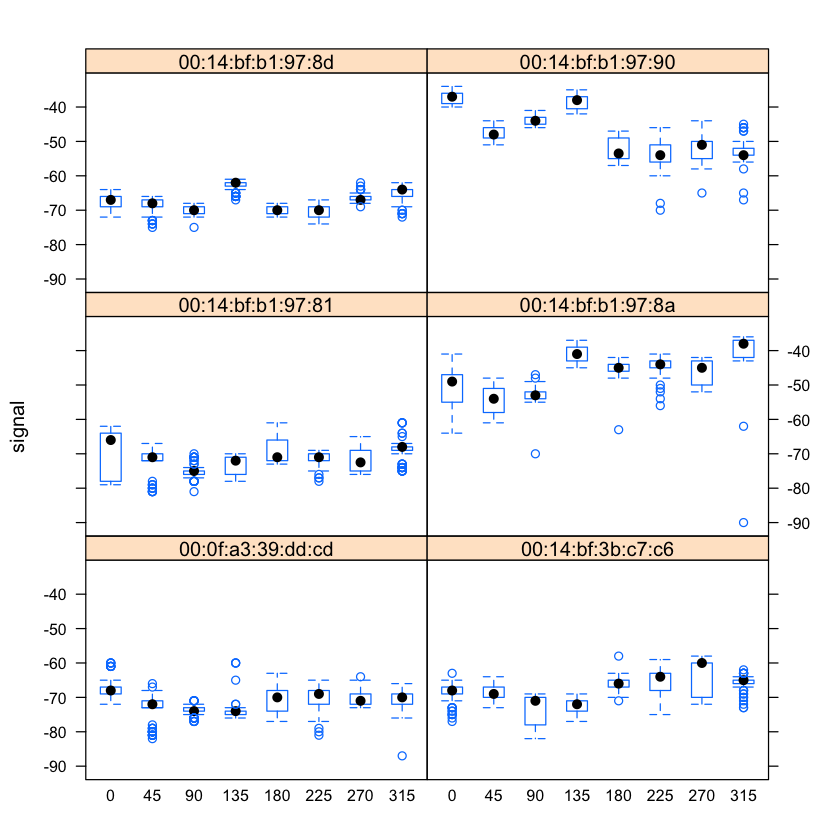

In [416]:
subMacs = c("00:0f:a3:39:e1:c0", "00:0f:a3:39:dd:cd", "00:14:bf:b1:97:8a",
                       "00:14:bf:3b:c7:c6", "00:14:bf:b1:97:90", "00:14:bf:b1:97:8d", "00:14:bf:b1:97:81")
filteredAccessPoint = "00:0f:a3:39:e1:c0"
usedAccessPoints = subMacs[subMacs != filteredAccessPoint] 
offlineRedo = readData(subMacs = usedAccessPoints)

oldPar = par(mar = c(3.1, 3, 1, 1))

library(lattice)
bwplot(signal ~ factor(angle) | mac, data = offlineRedo, 
       subset = posX == 2 & posY == 12 
       & mac != filteredAccessPoint
       , 
       layout = c(2,3))

par(oldPar)
dev.off()

#-----------------------------------------
# In the following code, we compare the distributions of signal strength for different angles and MAC addresses 
# at the central location of x = 23 and y = 4. Lack of normal distribution in the following plot illustrates that
# conditioning on angle and MAC address is warranted. If the distributions were normal, we could conclude that 
# signal can be received from different angles but that does not seem to be the case.
#-----------------------------------------
summary(offlineRedo$signal)

oldPar = par(mar = c(3.1, 3, 1, 1))

densityplot( ~ signal | mac + factor(angle), data = offlineRedo,
             subset = posX == 24 & posY == 4  
             & mac != filteredAccessPoint
            ,bw = 0.5, plot.points = FALSE)

par(oldPar)
dev.off()
#-----------------------------------------
# If we want to examine the distribution of signal strength for all 166 locations, 8 angles, and 6 access points, 
# we need to create thousands of boxplots or density curves. We can, instead, examine summary statistics such as 
# the mean and SD or the median and IQR of signal strength for all location–orientation–access point combinations. 
# For each combination, we have roughly 100 observations. To compute summary statistics for these various 
# combinations, we first create a special factor that contains all of the unique combinations of the observed (x, y)
# pairs for the 166 locations.
#-----------------------------------------
# offline = offline[ offline$mac != "00:0f:a3:39:dd:cd", ]
offlineRedo$posXY = paste(offlineRedo$posX, offlineRedo$posY, sep = "-")

byLocAngleAP = with(offlineRedo, 
                    by(offlineRedo, list(posXY, angle, mac), 
                       function(x) x))

signalSummary = 
  lapply(byLocAngleAP,            
         function(oneLoc) {
           ans = oneLoc[1, ]
           ans$medSignal = median(oneLoc$signal)
           ans$avgSignal = mean(oneLoc$signal)
           ans$num = length(oneLoc$signal)
           ans$sdSignal = sd(oneLoc$signal)
           ans$iqrSignal = IQR(oneLoc$signal)
           ans
           })

offlineSummary = do.call("rbind", signalSummary)                         

oldPar = par(mar = c(3.1, 3, 1, 1))

breaks = seq(-90, -30, by = 5)
bwplot(sdSignal ~ cut(avgSignal, breaks = breaks),
       data = offlineSummary, 
       subset = mac != filteredAccessPoint,
       xlab = "Mean Signal", ylab = "SD Signal")

par(oldPar)
dev.off()   
                                          
                                           
oldPar = par(mar = c(4.1, 4.1, 1, 1))

with(offlineSummary,
     smoothScatter((avgSignal - medSignal) ~ num,
                   xlab = "Number of Observations", 
                   ylab = "mean - median"))
abline(h = 0, col = "#984ea3", lwd = 2)

lo.obj = 
  with(offlineSummary,
       loess(diff ~ num, data = data.frame(diff = (avgSignal - medSignal), num = num)))

lo.obj.pr = predict(lo.obj, newdata = data.frame(num = (70:120)))
lines(x = 70:120, y = lo.obj.pr, col = "#4daf4a", lwd = 2)

par(oldPar)
dev.off()
 
oneAPAngle = subset(offlineSummary, mac == subMacs[5] & angle == 0)         
#-----------------------------------------
#-----------------------------------------                       
                       
list.of.packages <- c("fields")
new.packages <- list.of.packages[!(list.of.packages %in% installed.packages()[,"Package"])]
if(length(new.packages)) install.packages(new.packages)


library(fields)
smoothSS = Tps(oneAPAngle[, c("posX","posY")], oneAPAngle$avgSignal)

vizSmooth = predictSurface(smoothSS)

plot.surface(vizSmooth, type = "C")

points(oneAPAngle$posX, oneAPAngle$posY, pch=19, cex = 0.5)                      

unique(offlineSummary$mac)
                       
surfaceSS = function(data, mac, angle = 45) {
  require(fields)
  oneAPAngle = data[ data$mac == mac & data$angle == angle, ]
  smoothSS = Tps(oneAPAngle[, c("posX","posY")], oneAPAngle$avgSignal)
  vizSmooth = predictSurface(smoothSS)
  plot.surface(vizSmooth, type = "C", xlab = "", ylab = "", xaxt = "n", yaxt = "n")
  points(oneAPAngle$posX, oneAPAngle$posY, pch=19, cex = 0.5) 
}

parCur = par(mfrow = c(2,2), mar = rep(1, 4))


mapply(surfaceSS, mac = usedAccessPoints[ rep(c(5, 2), each = 2) ], 
        angle = rep(c(0, 135), 2),
        data = list(data = offlineSummary))
 
  par(parCur)

 offlineSummary = subset(offlineSummary, mac != filteredAccessPoint)
                       
AP = matrix( c( 7.5, 6.3, 2.5, -.8, 12.8, -2.8,  
                1, 14, 33.5, 9.3,  33.5, 2.8),
            ncol = 2, byrow = TRUE,
            dimnames = list(usedAccessPoints, c("x", "y") ))
   
   

#-----------------------------------------
#-----------------------------------------                        
                       
                       
                       
diffs = offlineSummary[ , c("posX", "posY")] - AP[ offlineSummary$mac, ]

offlineSummary$dist = sqrt(diffs[ , 1]^2 + diffs[ , 2]^2)

xyplot(signal ~ dist | factor(mac) + factor(angle), 
       data = offlineSummary, pch = 19, cex = 0.3,
       xlab ="distance")

oldPar = par(mar = c(3.1, 3.1, 1, 1))
library(lattice)
xyplot(signal ~ dist | factor(mac) + factor(angle), 
       data = offlineSummary, pch = 19, cex = 0.3,
       xlab ="distance")
par(oldPar)
dev.off()

macs = unique(offlineSummary$mac)                                                               

At this point, we have a set of training data that we can use to predict the location of our new point. We want to look at the distance in terms of signal strengths from these training data to the new point. If we would like to use the nearest neighbor or the 3 nearest neighbors, we need to calculate the distance from the new point to all observations in the training set. The following code prepares the data the run the K nearest neighbors:

Warning message in readLines(filename):
“ligne finale incomplète trouvée dans 'data/online.final.trace.txt'”

[1] 60

            
               0  45  90 135 180 225 270 315
  0-0.05       0   0   0 594   0   0   0   0
  0.15-9.42    0   0 608   0   0   0   0   0
  0.31-11.09   0   0   0   0   0 574   0   0
  0.47-8.2   591   0   0   0   0   0   0   0
  0.78-10.94 585   0   0   0   0   0   0   0
  0.93-11.69   0   0   0   0 581   0   0   0

[1] 60 11

[1] "posXY"             "posX"              "posY"             
 [4] "orientation"       "angle"             "00:0f:a3:39:dd:cd"
 [7] "00:14:bf:3b:c7:c6" "00:14:bf:b1:97:81" "00:14:bf:b1:97:8a"
[10] "00:14:bf:b1:97:8d" "00:14:bf:b1:97:90"

null device 
          1

null device 
          1

[1] 412 270

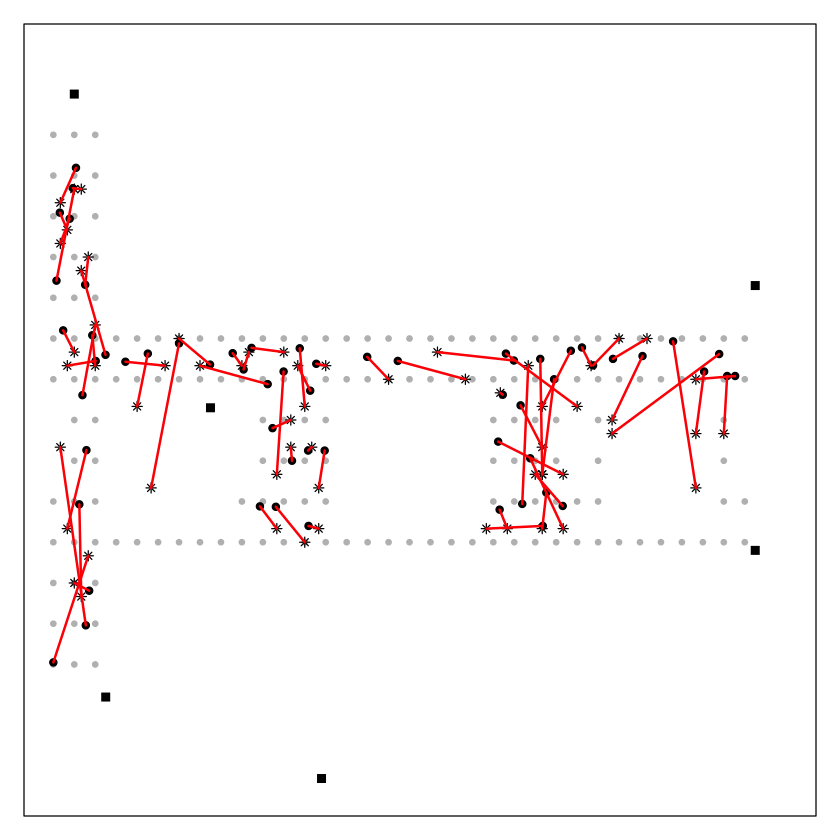

In [417]:
online = readData("data/online.final.trace.txt", subMacs = macs)

online$posXY = paste(online$posX, online$posY, sep = "-")

length(unique(online$posXY))

tabonlineXYA = table(online$posXY, online$angle)
tabonlineXYA[1:6, ]

keepVars = c("posXY", "posX","posY", "orientation", "angle")
byLoc = with(online, 
             by(online, list(posXY), 
                function(x) {
                  ans = x[1, keepVars]
                  avgSS = tapply(x$signal, x$mac, mean)
                  y = matrix(avgSS, nrow = 1, ncol = 6,
                        dimnames = list(ans$posXY, names(avgSS)))
                  cbind(ans, y)
                }))

onlineSummary = do.call("rbind", byLoc)  
dim(onlineSummary)

names(onlineSummary)
m = 3; angleNewObs = 230
refs = seq(0, by = 45, length  = 8)
nearestAngle = roundOrientation(angleNewObs)
  
if (m %% 2 == 1) {
  angles = seq(-45 * (m - 1) /2, 45 * (m - 1) /2, length = m)
} else {
  m = m + 1
  angles = seq(-45 * (m - 1) /2, 45 * (m - 1) /2, length = m)
  if (sign(angleNewObs - nearestAngle) > -1) 
    angles = angles[ -1 ]
  else 
    angles = angles[ -m ]
}
angles = angles + nearestAngle
angles[angles < 0] = angles[ angles < 0 ] + 360
angles[angles > 360] = angles[ angles > 360 ] - 360
offlineSubset = 
  offlineSummary[ offlineSummary$angle %in% angles, ]

reshapeSS = function(data, varSignal = "signal", 
                     keepVars = c("posXY", "posX","posY")) {
  byLocation =
    with(data, by(data, list(posXY), 
                  function(x) {
                    ans = x[1, keepVars]
                    avgSS = tapply(x[ , varSignal ], x$mac, mean)
                    y = matrix(avgSS, nrow = 1, ncol = 6,
                               dimnames = list(ans$posXY,
                                               names(avgSS)))
                    cbind(ans, y)
                  }))

  newDataSS = do.call("rbind", byLocation)
  return(newDataSS)
}

trainSS = reshapeSS(offlineSubset, varSignal = "avgSignal")

selectTrain = function(angleNewObs, signals = NULL, m = 1) {
  # m is the number of angles to keep between 1 and 5
  refs = seq(0, by = 45, length  = 8)
  nearestAngle = roundOrientation(angleNewObs)
  
  if (m %% 2 == 1) 
    angles = seq(-45 * (m - 1) /2, 45 * (m - 1) /2, length = m)
  else {
    m = m + 1
    angles = seq(-45 * (m - 1) /2, 45 * (m - 1) /2, length = m)
    if (sign(angleNewObs - nearestAngle) > -1) 
      angles = angles[ -1 ]
    else 
      angles = angles[ -m ]
  }
  angles = angles + nearestAngle
  angles[angles < 0] = angles[ angles < 0 ] + 360
  angles[angles > 360] = angles[ angles > 360 ] - 360
  angles = sort(angles) 
  
  offlineSubset = signals[ signals$angle %in% angles, ]
  reshapeSS(offlineSubset, varSignal = "avgSignal")
}

train130 = selectTrain(130, offlineSummary, m = 3)

#head(train130)

#length(train130[[1]])

findNN = function(newSignal, trainSubset) {
  diffs = apply(trainSubset[ , 4:9], 1, 
                function(x) x - newSignal)
  dists = apply(diffs, 2, function(x) sqrt(sum(x^2)) )
  closest = order(dists)
  return(trainSubset[closest, 1:3 ])
}
                
predXY = function(newSignals, newAngles, trainData, numAngles = 1, k = 3) {
  
  closeXY = list(length = nrow(newSignals))
  
  for (i in 1:nrow(newSignals)) {
    trainSS = selectTrain(newAngles[i], trainData, m = numAngles)
    closeXY[[i]] = 
      findNN(newSignal = as.numeric(newSignals[i, ]), trainSS)
  }

  estXY = lapply(closeXY, 
                 function(x) sapply(x[ , 2:3], 
                                    function(x) mean(x[1:k])))
  estXY = do.call("rbind", estXY)
  return(estXY)
}
estXYk3 = predXY(newSignals = onlineSummary[ , 6:11], 
                 newAngles = onlineSummary[ , 4], 
                 offlineSummary, numAngles = 3, k = 3)
                                    

estXYk1 = predXY(newSignals = onlineSummary[ , 6:11], 
                 newAngles = onlineSummary[ , 4], 
                 offlineSummary, numAngles = 3, k = 1)   
                                    
floorErrorMap = function(estXY, actualXY, trainPoints = NULL, AP = NULL) {
  
    plot(0, 0, xlim = c(0, 35), ylim = c(-3, 15), type = "n",
         xlab = "", ylab = "", axes = FALSE)
    cap <- "Figure x: Prediction vs. Real Location"
    box()
    if ( !is.null(AP) ) points(AP, pch = 15)
    if ( !is.null(trainPoints) )
      points(trainPoints, pch = 19, col="grey", cex = 0.6)
    
    points(x = actualXY[, 1], y = actualXY[, 2], 
           pch = 19, cex = 0.8 )
    points(x = estXY[, 1], y = estXY[, 2], 
           pch = 8, cex = 0.8 )
    segments(x0 = estXY[, 1], y0 = estXY[, 2],
             x1 = actualXY[, 1], y1 = actualXY[ , 2],
             lwd = 2, col = "red")
}

trainPoints = offlineSummary[ offlineSummary$angle == 0 & 
                              offlineSummary$mac == "00:0f:a3:39:dd:cd" ,
                        c("posX", "posY")]                                    

# pdf(file="GEO_FloorPlanK3Errors.pdf", width = 10, height = 7)
oldPar = par(mar = c(1, 1, 1, 1))
floorErrorMap(estXYk3, onlineSummary[ , c("posX","posY")], 
              trainPoints = trainPoints, AP = AP)
par(oldPar)
dev.off()

#pdf(file="GEO_FloorPlanK1Errors.pdf", width = 10, height = 7)
oldPar = par(mar = c(1, 1, 1, 1))
floorErrorMap(estXYk1, onlineSummary[ , c("posX","posY")], 
              trainPoints = trainPoints, AP = AP)
par(oldPar)
dev.off()

calcError = 
function(estXY, actualXY) 
   sum( rowSums( (estXY - actualXY)^2) )

actualXY = onlineSummary[ , c("posX", "posY")]
sapply(list(estXYk1, estXYk3), calcError, actualXY)

                                    

# Predicting the location with new access point data 
The following code prepares the essential folds of offline data (with the new access point data) so that we can predict the location and calculate the root mean square error rate for different number of neighbors in the range of 1 to 20. This will help us plot the root mean square error vs. the number of neighbors and analyze the way new access point contributes to our prediction model. 

In [418]:
set.seed(seed = seed)
v = 11
permuteLocs = sample(unique(offlineSummary$posXY))
permuteLocs = matrix(permuteLocs, ncol = v, 
                     nrow = floor(length(permuteLocs)/v))

onlineFold = subset(offlineSummary, posXY %in% permuteLocs[ , 1])

reshapeSS = function(data, varSignal = "signal", 
                     keepVars = c("posXY", "posX","posY"),
                     sampleAngle = FALSE, 
                     refs = seq(0, 315, by = 45)) {
  byLocation =
    with(data, by(data, list(posXY), 
                  function(x) {
                    if (sampleAngle) {
                      x = x[x$angle == sample(refs, size = 1), ]}
                    ans = x[1, keepVars]
                    avgSS = tapply(x[ , varSignal ], x$mac, mean)
                    y = matrix(avgSS, nrow = 1, ncol = 6,
                               dimnames = list(ans$posXY,
                                               names(avgSS)))
                    cbind(ans, y)
                  }))

  newDataSS = do.call("rbind", byLocation)
  return(newDataSS)
}


offlineRedo = offlineRedo[ offlineRedo$mac != filteredAccessPoint, ]

keepVars = c("posXY", "posX","posY", "orientation", "angle")

onlineCVSummary = reshapeSS(offlineRedo, keepVars = keepVars, 
                            sampleAngle = TRUE)

onlineFold = subset(onlineCVSummary, 
                    posXY %in% permuteLocs[ , 1])

offlineFold = subset(offlineSummary,
                     posXY %in% permuteLocs[ , -1])

estFold = predXY(newSignals = onlineFold[ , 6:11], 
                 newAngles = onlineFold[ , 4], 
                 offlineFold, numAngles = 3, k = 3)

actualFold = onlineFold[ , c("posX", "posY")]
calcError(estFold, actualFold)

K = 20
err = rep(0, K)

for (j in 1:v) {
  onlineFold = subset(onlineCVSummary, 
                      posXY %in% permuteLocs[ , j])
  offlineFold = subset(offlineSummary,
                       posXY %in% permuteLocs[ , -j])
  actualFold = onlineFold[ , c("posX", "posY")]
  
  for (k in 1:K) {
    estFold = predXY(newSignals = onlineFold[ , 6:11],
                     newAngles = onlineFold[ , 4], 
                     offlineFold, numAngles = 3, k = k)
    err[k] = err[k] + calcError(estFold, actualFold)
  }
}

Warning message in matrix(permuteLocs, ncol = v, nrow = floor(length(permuteLocs)/v)):
“la longueur des données [166] n'est pas un diviseur ni un multiple du nombre de lignes [15]”

[1] 25

## Plotting the root mean square error rate
When we compare this plot with Nolan and Lang code, we observe that our access point ("00:0f:a3:39:dd:cd") leads to a smaller root mean square error rate with the same number of neighbors(k=5) and the "calcError" function yields almost the same number (249.9243). We conclude that the access point "00:0f:a3:39:dd:cd" has a better contribution to the model.

[1] 1232

[1] 250

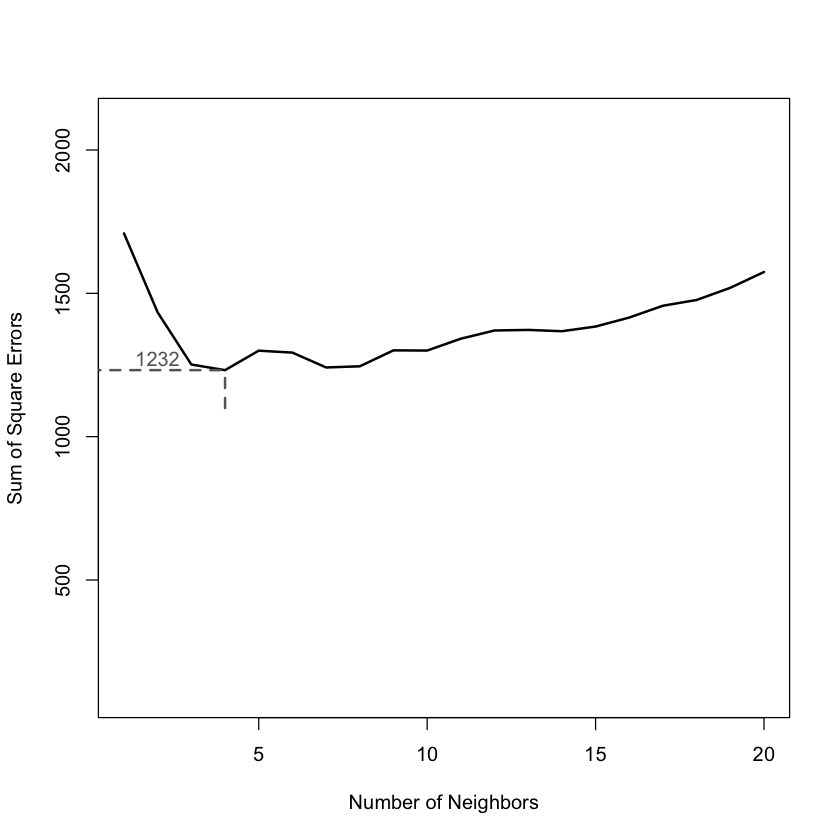

In [419]:
set.seed(seed = seed)
plot(y = err, x = (1:K),  type = "l", lwd= 2,
     ylim = c(100, 2100),
     xlab = "Number of Neighbors",
     ylab = "Sum of Square Errors")

rmseMin = min(err)
rmseMin
kMin = which(err == rmseMin)[1]
segments(x0 = 0, x1 = kMin, y0 = rmseMin, col = gray(0.4), 
         lty = 2, lwd = 2)
segments(x0 = kMin, x1 = kMin, y0 = 1100,  y1 = rmseMin, 
         col = grey(0.4), lty = 2, lwd = 2)
text(x = kMin - 2, y = rmseMin + 40, 
     label = as.character(round(rmseMin)), col = grey(0.4))

estXYk5 = predXY(newSignals = onlineSummary[ , 6:11], 
                 newAngles = onlineSummary[ , 4], 
                 offlineSummary, numAngles = 3, k = 5)

calcError(estXYk5, actualXY)

## Having both access points
Now we would like to know whether we can have a better model with both access points in the data. As they are roughly in the same location, the result might not differ as much. But we try to find an answer for this question in the following: 

In [420]:
set.seed(seed = seed)
subMacs = c("00:0f:a3:39:e1:c0", "00:0f:a3:39:dd:cd", "00:14:bf:b1:97:8a",
                       "00:14:bf:3b:c7:c6", "00:14:bf:b1:97:90", "00:14:bf:b1:97:8d",
                       "00:14:bf:b1:97:81")
filteredAccessPoint = ""
usedAccessPoints = subMacs 
offlineRedo = readData()

oldPar = par(mar = c(3.1, 3, 1, 1))

offlineRedo$posXY = paste(offlineRedo$posX, offlineRedo$posY, sep = "-")

byLocAngleAP = with(offlineRedo, 
                    by(offlineRedo, list(posXY, angle, mac), 
                       function(x) x))

signalSummary = 
  lapply(byLocAngleAP,            
         function(oneLoc) {
           ans = oneLoc[1, ]
           ans$medSignal = median(oneLoc$signal)
           ans$avgSignal = mean(oneLoc$signal)
           ans$num = length(oneLoc$signal)
           ans$sdSignal = sd(oneLoc$signal)
           ans$iqrSignal = IQR(oneLoc$signal)
           ans
           })

offlineSummary = do.call("rbind", signalSummary)                         

macs = unique(offlineSummary$mac)    
macs                       
    
online = readData("data/online.final.trace.txt", subMacs = macs)

online$posXY = paste(online$posX, online$posY, sep = "-")

length(unique(online$posXY))

tabonlineXYA = table(online$posXY, online$angle)
tabonlineXYA[1:7, ]

keepVars = c("posXY", "posX","posY", "orientation", "angle")
byLoc = with(online, 
             by(online, list(posXY), 
                function(x) {
                  ans = x[1, keepVars]
                  avgSS = tapply(x$signal, x$mac, mean)
                  y = matrix(avgSS, nrow = 1, ncol = 7,
                        dimnames = list(ans$posXY, names(avgSS)))
                  cbind(ans, y)
                }))

onlineSummary = do.call("rbind", byLoc)  


names(onlineSummary)
m = 3; angleNewObs = 230
refs = seq(0, by = 45, length  = 8)
nearestAngle = roundOrientation(angleNewObs)
  
if (m %% 2 == 1) {
  angles = seq(-45 * (m - 1) /2, 45 * (m - 1) /2, length = m)
} else {
  m = m + 1
  angles = seq(-45 * (m - 1) /2, 45 * (m - 1) /2, length = m)
  if (sign(angleNewObs - nearestAngle) > -1) 
    angles = angles[ -1 ]
  else 
    angles = angles[ -m ]
}
angles = angles + nearestAngle
angles[angles < 0] = angles[ angles < 0 ] + 360
angles[angles > 360] = angles[ angles > 360 ] - 360
offlineSubset = 
  offlineSummary[ offlineSummary$angle %in% angles, ]

reshapeSS = function(data, varSignal = "signal", 
                     keepVars = c("posXY", "posX","posY")) {
  byLocation =
    with(data, by(data, list(posXY), 
                  function(x) {
                    ans = x[1, keepVars]
                    avgSS = tapply(x[ , varSignal ], x$mac, mean)
                    y = matrix(avgSS, nrow = 1, ncol = 7,
                               dimnames = list(ans$posXY,
                                               names(avgSS)))
                    cbind(ans, y)
                  }))

  newDataSS = do.call("rbind", byLocation)
  return(newDataSS)
}

trainSS = reshapeSS(offlineSubset, varSignal = "avgSignal")

selectTrain = function(angleNewObs, signals = NULL, m = 1) {
  # m is the number of angles to keep between 1 and 5
  refs = seq(0, by = 45, length  = 8)
  nearestAngle = roundOrientation(angleNewObs)
  
  if (m %% 2 == 1) 
    angles = seq(-45 * (m - 1) /2, 45 * (m - 1) /2, length = m)
  else {
    m = m + 1
    angles = seq(-45 * (m - 1) /2, 45 * (m - 1) /2, length = m)
    if (sign(angleNewObs - nearestAngle) > -1) 
      angles = angles[ -1 ]
    else 
      angles = angles[ -m ]
  }
  angles = angles + nearestAngle
  angles[angles < 0] = angles[ angles < 0 ] + 360
  angles[angles > 360] = angles[ angles > 360 ] - 360
  angles = sort(angles) 
  
  offlineSubset = signals[ signals$angle %in% angles, ]
  reshapeSS(offlineSubset, varSignal = "avgSignal")
}

train130 = selectTrain(130, offlineSummary, m = 3)

findNN = function(newSignal, trainSubset) {
  diffs = apply(trainSubset[ , 4:9], 1, 
                function(x) x - newSignal)
  dists = apply(diffs, 2, function(x) sqrt(sum(x^2)) )
  closest = order(dists)
  return(trainSubset[closest, 1:3 ])
}
                
predXY = function(newSignals, newAngles, trainData, numAngles = 1, k = 3) {
  
  closeXY = list(length = nrow(newSignals))
  
  for (i in 1:nrow(newSignals)) {
    trainSS = selectTrain(newAngles[i], trainData, m = numAngles)
    closeXY[[i]] = 
      findNN(newSignal = as.numeric(newSignals[i, ]), trainSS)
  }

  estXY = lapply(closeXY, 
                 function(x) sapply(x[ , 2:3], 
                                    function(x) mean(x[1:k])))
  estXY = do.call("rbind", estXY)
  return(estXY)
}
                                    
estXYk3 = predXY(newSignals = onlineSummary[ , 6:11], 
                 newAngles = onlineSummary[ , 4], 
                 offlineSummary, numAngles = 3, k = 3)
                                    

estXYk1 = predXY(newSignals = onlineSummary[ , 6:11], 
                 newAngles = onlineSummary[ , 4], 
                 offlineSummary, numAngles = 3, k = 1)   
                                    

calcError = 
function(estXY, actualXY) 
   sum( rowSums( (estXY - actualXY)^2) )

actualXY = onlineSummary[ , c("posX", "posY")]
sapply(list(estXYk1, estXYk3), calcError, actualXY)                       

                                    
v = 11
permuteLocs = sample(unique(offlineSummary$posXY))
permuteLocs = matrix(permuteLocs, ncol = v, 
                     nrow = floor(length(permuteLocs)/v))

onlineFold = subset(offlineSummary, posXY %in% permuteLocs[ , 1])

reshapeSS = function(data, varSignal = "signal", 
                     keepVars = c("posXY", "posX","posY"),
                     sampleAngle = FALSE, 
                     refs = seq(0, 315, by = 45)) {
  byLocation =
    with(data, by(data, list(posXY), 
                  function(x) {
                    if (sampleAngle) {
                      x = x[x$angle == sample(refs, size = 1), ]}
                    ans = x[1, keepVars]
                    avgSS = tapply(x[ , varSignal ], x$mac, mean)
                    y = matrix(avgSS, nrow = 1, ncol = 7,
                               dimnames = list(ans$posXY,
                                               names(avgSS)))
                    cbind(ans, y)
                  }))

  newDataSS = do.call("rbind", byLocation)
  return(newDataSS)
}



 keepVars = c("posXY", "posX","posY", "orientation", "angle")

 onlineCVSummary = reshapeSS(offlineRedo, keepVars = keepVars, 
                             sampleAngle = TRUE)

 onlineFold = subset(onlineCVSummary, 
                     posXY %in% permuteLocs[ , 1])

offlineFold = subset(offlineSummary,
                     posXY %in% permuteLocs[ , -1])

estFold = predXY(newSignals = onlineFold[ , 6:11], 
                 newAngles = onlineFold[ , 4], 
                 offlineFold, numAngles = 3, k = 3)

actualFold = onlineFold[ , c("posX", "posY")]
calcError(estFold, actualFold)

K = 20
err = rep(0, K)

for (j in 1:v) {
  onlineFold = subset(onlineCVSummary, 
                      posXY %in% permuteLocs[ , j])
  offlineFold = subset(offlineSummary,
                       posXY %in% permuteLocs[ , -j])
  actualFold = onlineFold[ , c("posX", "posY")]
  
  for (k in 1:K) {
    estFold = predXY(newSignals = onlineFold[ , 6:11],
                     newAngles = onlineFold[ , 4], 
                     offlineFold, numAngles = 3, k = k)
    err[k] = err[k] + calcError(estFold, actualFold)
  }
}                                                      

[1] "00:0f:a3:39:dd:cd" "00:0f:a3:39:e1:c0" "00:14:bf:3b:c7:c6"
[4] "00:14:bf:b1:97:81" "00:14:bf:b1:97:8a" "00:14:bf:b1:97:8d"
[7] "00:14:bf:b1:97:90"

Warning message in readLines(filename):
“ligne finale incomplète trouvée dans 'data/online.final.trace.txt'”

[1] 60

            
               0  45  90 135 180 225 270 315
  0-0.05       0   0   0 704   0   0   0   0
  0.15-9.42    0   0 717   0   0   0   0   0
  0.31-11.09   0   0   0   0   0 684   0   0
  0.47-8.2   701   0   0   0   0   0   0   0
  0.78-10.94 695   0   0   0   0   0   0   0
  0.93-11.69   0   0   0   0 691   0   0   0
  1.08-12.19   0   0   0   0   0 742   0   0

[1] "posXY"             "posX"              "posY"             
 [4] "orientation"       "angle"             "00:0f:a3:39:dd:cd"
 [7] "00:0f:a3:39:e1:c0" "00:14:bf:3b:c7:c6" "00:14:bf:b1:97:81"
[10] "00:14:bf:b1:97:8a" "00:14:bf:b1:97:8d" "00:14:bf:b1:97:90"

[1] 510 244

Warning message in matrix(permuteLocs, ncol = v, nrow = floor(length(permuteLocs)/v)):
“la longueur des données [166] n'est pas un diviseur ni un multiple du nombre de lignes [15]”

[1] 71

## Plotting the root mean square error rate with both access points
The following plot illustrates a similiar trend. Very few access points and too many of them 
contribute to the root mean square error of predicted location. When we compare this plot with the corresponding previous 
plots , we observe that having both access points as part of the model will lead to a lower root mean square error (1337) compared to the original approach but it is not as good as having only "00:0f:a3:39:dd:cd" access point. The result makes sense as "00:0f:a3:39:e1:c0", "00:0f:a3:39:dd:cd" access points are close to each other and their combination should not significantly contribute to the accuracy of the predicted locations (if we disregard the impact of signal strength).

[1] 1182

[1] 228

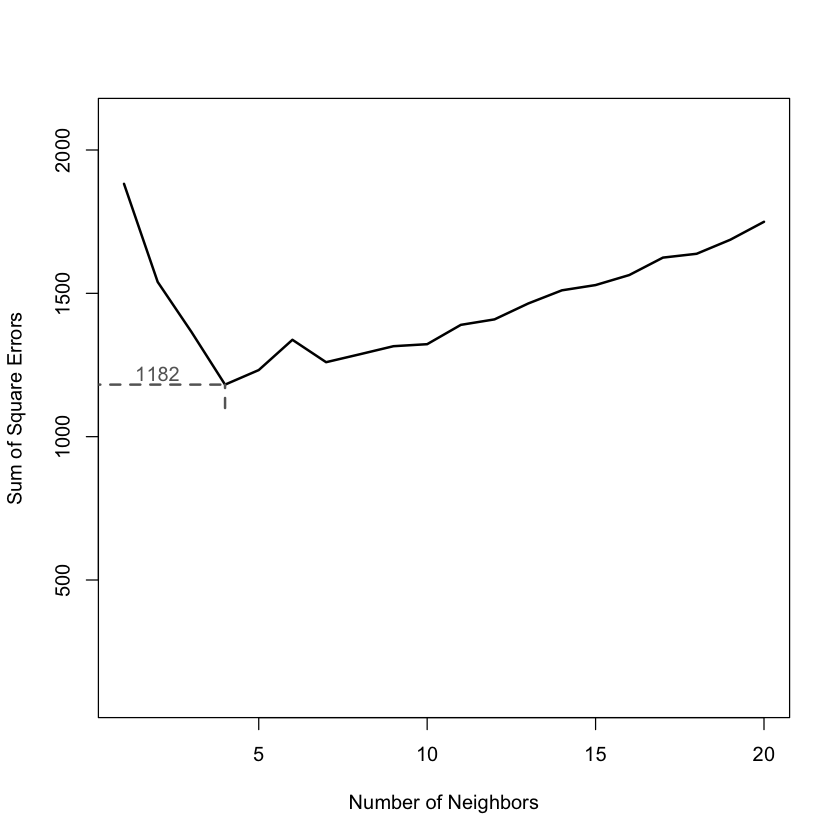

In [421]:
set.seed(seed = seed)
plot(y = err, x = (1:K),  type = "l", lwd= 2,
     ylim = c(100, 2100),
     xlab = "Number of Neighbors",
     ylab = "Sum of Square Errors")

rmseMin = min(err)
rmseMin
kMin = which(err == rmseMin)[1]
segments(x0 = 0, x1 = kMin, y0 = rmseMin, col = gray(0.4), 
         lty = 2, lwd = 2)
segments(x0 = kMin, x1 = kMin, y0 = 1100,  y1 = rmseMin, 
         col = grey(0.4), lty = 2, lwd = 2)
text(x = kMin - 2, y = rmseMin + 40, 
     label = as.character(round(rmseMin)), col = grey(0.4))

estXYk5 = predXY(newSignals = onlineSummary[ , 6:11], 
                 newAngles = onlineSummary[ , 4], 
                 offlineSummary, numAngles = 3, k = 5)

calcError(estXYk5, actualXY)

We revert the data back into the best shape we have concluded so far which is removing "00:0f:a3:39:e1:c0" access point.

[1] 112

[1] "00:0f:a3:39:dd:cd" "00:0f:a3:39:e1:c0" "00:14:bf:3b:c7:c6"
[4] "00:14:bf:b1:97:81" "00:14:bf:b1:97:8a" "00:14:bf:b1:97:8d"
[7] "00:14:bf:b1:97:90"

## KNN Distance Weighting
Now that we have chosen the better access point of the two, we estimate positions by average X-Y location across k nearest points. The distance of the points may influence the accuracy of the model.  We apply weights to the XY positions of each k closest locations to evaluate the influence. Rather than  averaging the values, we will take the sum of those results. With the below formula, we are able to compute weights for each k closest observations.

$$
\begin{aligned}
\frac{1/d_i}{\sum_{i=1}^{k}1/d_i}
\end{aligned}
$$
The findNN function has been modified from the previous version to return the distance metrics as well(It is used in determining the closest k points). Moreover, predXY function is improved to conduct weight computation (with the mentioned formula). These weights are each multiplied against each k nearest observation, then summed to compute weighted estimation by distance. These new calculations might allow locations of closer distances to be more impactful than those further away (instead of equal weighting among the k points).

In [423]:
findNN = function(newSignal, trainSubset) {
  diffs = apply(trainSubset[ , 4:9], 1, 
                function(x) x - newSignal)
  dists = apply(diffs, 2, function(x) sqrt(sum(x^2)) )
  closest = order(dists)
  return(list(trainSubset[closest, 1:3 ], dists[order(dists)]))
}

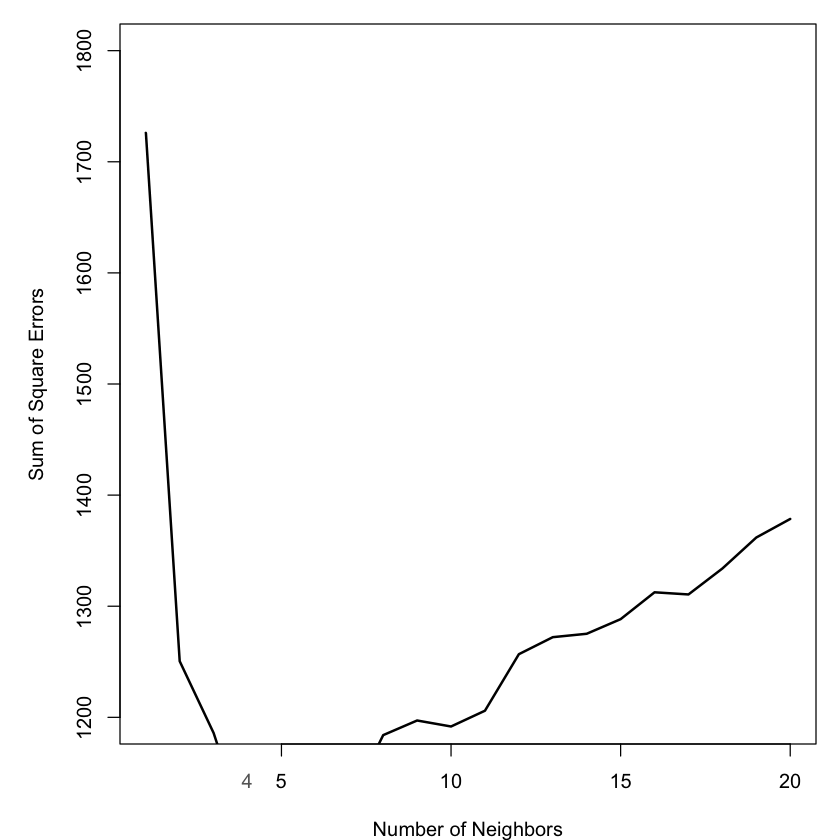

In [429]:
set.seed(seed = seed)
predXY = function(newSignals, newAngles, trainData, numAngles = 1, k = 3){
  
  closeXY = list(length = nrow(newSignals))
  closeDist = list(length = nrow(newSignals))
  
  for (i in 1:nrow(newSignals)) {
    trainSS = selectTrain(newAngles[i], trainData, m = numAngles)
    fnnResult = findNN(newSignal = as.numeric(newSignals[i, ]), trainSS)
  
    closeXY[[i]] = fnnResult[[1]]
    closeDist[[i]] = fnnResult[[2]]
  }
  
  distWeight = list(length = length(closeDist))
  
  for (i in 1:length(closeDist)){
    distW = list(length = k)

    for (j in 1:k){
      distW[j] = (1/closeDist[[i]][j])/sum(1/closeDist[[i]][1:k])
    }
     
    distWeight[[i]] =  distW
  }

  estXYDetails = list(length=length(closeXY))
  
  for(i in 1:length(closeXY)){
    estXYDetails[[i]] = as.matrix(closeXY[[i]][1:k,2:3]) * unlist(distWeight[[i]])
  }
  
  estXY = lapply(estXYDetails,
                 function(x) apply(x, 2,
                                   function(x) sum(x)))
    
  estXY = do.call("rbind", estXY)
  return(estXY)
}
                                   
K = 20
err = rep(0, K)

for (j in 1:v) {
  onlineFold = subset(onlineCVSummary, 
                      posXY %in% permuteLocs[ , j])
  offlineFold = subset(offlineSummary,
                       posXY %in% permuteLocs[ , -j])
  actualFold = onlineFold[ , c("posX", "posY")]
  
  for (k in 1:K) {
    estFold = predXY(newSignals = onlineFold[ , 6:11],
                     newAngles = onlineFold[ , 4], 
                     offlineFold, numAngles = 3, k = k)
    err[k] = err[k] + calcError(estFold, actualFold)
  }
} 
                                   
oldPar = par(mar = c(4, 5, 1, 1))
plot(y = err, x = (1:K),  type = "l", lwd= 2,
     ylim = c(1200, 1800),
     xlab = "Number of Neighbors",
     ylab = "Sum of Square Errors")
rmseMin = min(err)
kMin2 = which(err == rmseMin)[1]
segments(x0 = 0, x1 = kMin2, y0 = rmseMin, col = gray(0.4), 
         lty = 2, lwd = 2)
segments(x0 = kMin2, x1 = kMin2, y0 = 900,  y1 = rmseMin, 
         col = grey(0.4), lty = 2, lwd = 2)

mtext(kMin2, side = 1, line = 1, at = kMin2, col = grey(0.4))
text(x = kMin2 - 2, y = rmseMin + 40, 
     label = as.character(round(rmseMin)), col = grey(0.4))
par(oldPar)                                   

In [430]:
set.seed(seed = seed)
estXYk8 = predXY(newSignals = onlineSummary[ , 6:11], 
                 newAngles = onlineSummary[ , 4], 
                 offlineSummary, numAngles = 4, k = 4)

calcError(estXYk8, actualXY)

[1] 205

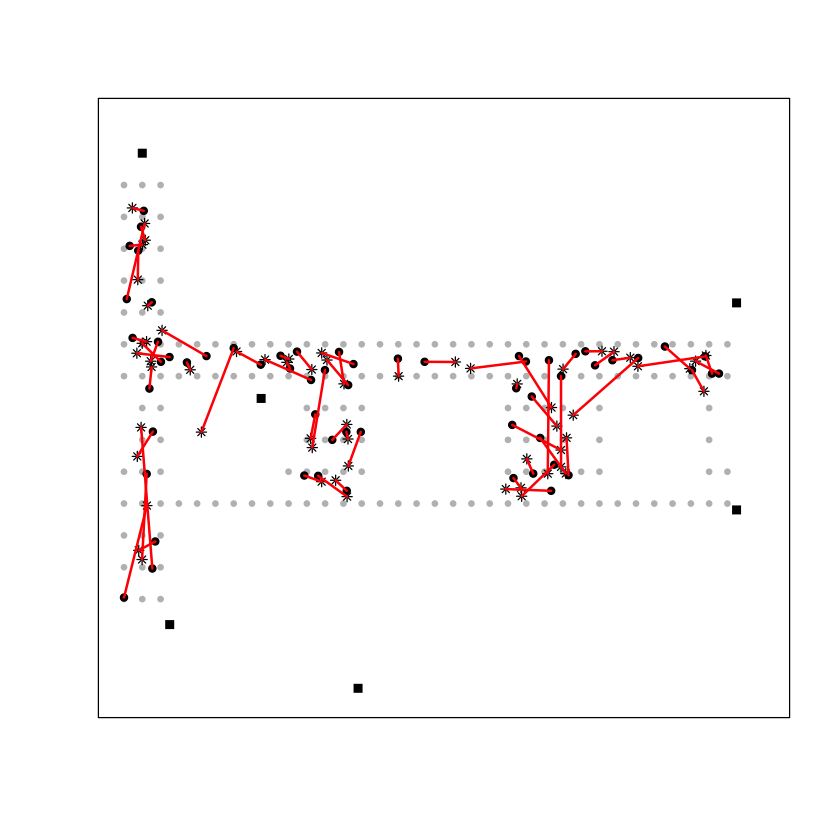

In [426]:
oldPar = par(mar = c(1, 1, 1, 1))
par(oldPar)
floorErrorMap(estXYk8, onlineSummary[ , c("posX","posY")], trainPoints = trainPoints, AP = AP)

With our optimal k value (equal to 4) selected for number of nearest points, we compute predictions using the weighted distance estimation method, storing the RSSE values for comparison to the average location methods.    


## Conclusion
 Estimations are compared using RMSE values. Visually, errors in Nolan and Lang original model and KNN with distance weighting both seem to show more errors in the narrow hallways. This large error makes sense due to density of observations. Overall, differences in these outputs show very similar results with some errors being largely minimized by the weighted distance strategy and removing the "" access point. Using different K values and distance methods, the error rate gradually decreased from 659.4003 to 306.702522222222 to 275.5083 to 228.3443, and finally to 204.515442734201. We wish we had more time to improve our model using log transformed and time features and other distance methods to minimize the RMSE even more.

## Reference
Nolan, D., Temple Lang, D. DATA SCIENCE IN R: a Case Studies Approach to Computational Reasoning and Problem Solving. CRC PRESS, 2017

The distance function effect on k-nearest neighbor classification for medical datasets. [Link](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4978658/)
